# Сбор данных с Web-scraping и API для социально-научных исследований
---
## Семинары 5-6. `BeautifulSoup` и `requests`: продолжение.

---
*ФСН, ОП "Политология", 2023-2024 гг.*

Лика Капустина,

lkapustina@hse.ru

**План занятия:**
1. [Этап 2.1 Собираем данные со страницы преподавателя на одном примере](#par1)
2. [Этап 2.2 Собираем данные о преподавателях в цикле](#par2)
3. [Обработка полученных данных и `pandas`](#par3)
4. [Анализ данных и визуализации](#par4)
5. [Дополнительные материалы](#parlast)
---

**Что было на предыдущем семинаре?**
* Мы с вами поговорили про библиотеки `requests` и `bs4`;
* Вспомнили основы работы с некоторыми базовыми конструкциями в Python;
* Сформулировали цель и этапы нашего проекта – мы хотим собрать и проанализироватьданные о преподавателях ОП "Политология";
* Собрали ссылки на страницы преподавателей – в файл `links_political_science_bachelor_tutors.txt`.

Как мы обозначили раньше, **процесс сбора данных выглядит так:**
1. Сбор ссылок на страницы преподавателей (лежат на [странице с преподавателями](https://www.hse.ru/ba/political/tutors));
2. Сбор информации со страниц преподавателей (индивидуальные страницы преподавателей, организованные по одному шаблону).

**А после сбора данных мы:**

3. Займемся предобработкой данных и вспомним про то какие возможности `pandas` существуют;

4. Возьмемся за анализ данных и исследуем наши данные, а также построим несколько графиков с помощью `matplotlib` и `seaborn`.

**Первый этап сбора данных осуществлен, поэтому - переходим к этапу №2**

## 0. Загружаем необходимые библиотеки

In [2]:
import requests               # для отправки http запросов веб-серверам
from bs4 import BeautifulSoup # для обработки html
import pandas as pd           # для работы с таблицами
import numpy as np            # для базовых математических операций
import re                     # для работы с регулярными выражениями

## Этап 2.1 Собираем данные со страницы преподавателя на одном примере<a name="par1"></a>

Давайте сделаем запрос к одной странице преподавателя и сохраним результат в переменную `html`. В будущем, вы будете бесконечно использовать две эти строки:

Базовая схема выглядит просто: запрос через `requests` + обработка HTML через `BeautifulSoup`. Для этого нужно всего три строчки:

Для примера мы поработаем со страницей [Ильи Михайловича Локшина](https://www.hse.ru/org/persons/14276397). 

In [3]:
link = 'https://www.hse.ru/org/persons/14276397' # сохраняем ссылку в переменную
html = requests.get(link)                        # делаем к ней запрос
soup = BeautifulSoup(html.text)                  # обрабатываем html с помощью BeautifulSoup

<center><b>Какие данные мы будем собирать со страниц преподавателей?</b></center>

Лучше всего определиться с переменными, которые мы хотим собрать: это будут **основные переменные** и **дополнительные**.

**Почему хорошо в начале работы над проектом сформулировать такое разделение?**

В категорию **основные переменные** попадают те переменные, которые:
1. **Необходимо** собрать по техническому заданию от вашего работодателя/по вашему проекту;
2. Переменные, которые присутствуют **почти на любой странице** того типа, с которым мы будем работать;
    
Получением этих переменных из html-разметки страницы мы занимаемся до победного конца – пока не научимся собирать их и не протестируем сбор на ряде тестовых запросов, не прекращаем работу над проектом.
    
**Список основных параметров, которые мы будем собирать со страницы преподавателя:**

1. ФИО преподавателя;
2. Информация об образовании:
    * Степень бакалавра;
    * Степень магистра;
    * Степень кандидата наук (PhD);
3. Год старта работы в Вышке;
4. Профессиональные интересы;
5. Сколько раз преподаватель получал статус "лучшего преподавателя";
6. Иностранные языки, которые знает преподаватель;
7. Количество иностранных языков, которые знает преподаватель;
8. Ссылка на страницу преподавателя;
    
В категорию **дополнительные переменные** будут попадать те переменные, которые:
1. Можно собрать, но не требуется по условию т/з или задач проекта;
2. Если соберете – <font color='green'>хорошо</font>, если не соберете – <font color='grey'>некритично</font>;
3. Присутствуют, скорее всего, не на всех страницах такого типа (то есть, могут вызвать <font color='orange'>ошибки</font>);
4. Их сбор <font color='orange'>затруднен или невозможен</font> в рамках работы с теми инструментами, которые вы выбрали (например, определенное значение может быть получено только после нажатия на кнопки или отправки форм с которыми вы могли бы поработать используя `Selenium` + `bs4`, а вы пока умеете работать только с `requests` + `bs4`).
    



**Дополнительно можно собрать:**

1. Места работы в НИУ ВШЭ;
2. Должности на местах работы;
3. Количество публикаций преподавателя;
4. Количество новостей на сайте Вышки с преподавателем;
5. Названия курсов, которые он преподает;
6. ID в наукометрических системах:
    * Google Scholar;
    * SPIN РИНЦ;
    * ORCID;
    * ResearcherID;
    * Scopus Author ID
7. Является ли участником программы кадрового резерва;
8. Получал ли надбавку за академическую работу;
9. Являлся ли победителем конкурса лучших научных работ сотрудников НИУ ВШЭ;
10. Проекты на ярмарке проектов:
    * Руководил ли хотя бы 1 проектом или нет;
    * Число проектов под руководством преподавателя;
11. Информация об опыте работы;
12. Контакты, адрес работы;
13. Часы присутствия и/или время консультаций,

*и многое другое*. Эти данные присутствуют на странице не каждого преподавателя, но могут дополнить наше представление о преподавателях ОП "Политология".

<center><b>Как понять, какие данные вы вообще можете собрать со страницы, с которой работаете?</b></center>

**Базовый вариант – проходитесь по нескольким страницам (включая самые наполненные), и выписываете себе те данные, которые можете с неё собрать**.

**Иногда ваш заказчик или работодатель приходит к вам с конкретным списком** – нужно собрать такие-то переменные, и вы пишете скрипт, который получает необходимые данные со страницы.
<p></p>
<p></p>
<center><b>Как увидеть html-разметку страницы?</b></center>

Для того чтобы отработать сбор данных со страницы преподавателя на конкретном примере, откроем страницу одного преподавателя – это будет страница [Ильи Михайловича Локшина](https://www.hse.ru/org/persons/14276397) и пробежимся по ней. 

* **Вам нужно открыть его страницу в новом окне (я советую это сделать в браузере `Google Chrome`), нажать правой кнопкой мыши на экран и выбрать опцию `Показать код`.**

* **Если вы пользуетесь Safari и принципиально не хотите устанавливать новый браузер**, вам нужно:
    1. Открыть в Safari настройки приложения;
    2. Кликнуть на `"Дополнения"`;
    3. Нажать на `"Показывать меню "Разработка"` в строке меню";
    4. После этого навести курсор на элемент, нажать **ПКМ**, кликнуть на `Проверить инструмент`.
    
**Если на вашем экране вы увидели что-то похожее, то шалость удалась и теперь вы можете ориентироватся по html-разметке страницы**

![Страница](screen_1.png)

*Если у вас не отображается скриншот, перейдите по [ссылке](https://drive.google.com/file/d/1z6xRAmz8EIxuuuCY7Sd1cKLsfOXoYFAD/view?usp=share_link).*

**Когда вы ищите как получить конкретную информацию, вы можете опираться на две основные опции:**

1. **Найти нужную информацию на странице, кликнуть на этот элемент ПКМ и нажать `Показать код`**;

![Пример](screen_2.png)
*Если у вас не отображается скриншот, перейдите по [ссылке](https://drive.google.com/file/d/1ryhcIN-04zgJccHLx3rCbz6ob0erAR_Y/view?usp=share_link)*

2. **Нажать ПКМ, кликнуть `Показать код`, вызвать поисковую строку с помощью `Cmd` + `F` и ввести туда то значение, которое вы хотите получить** (например, ФИО, адрес, строку об учебе в бакалавриате).

![Пример](screen_3.png)

*Если у вас не отображается скриншот, перейдите по [ссылке](https://drive.google.com/file/d/1_GliL38txvu6SxF0TIylOgk5Frg29uif/view?usp=share_link)*.

### Этап 2. Создание скрипта и сбор базовой информации.

**Как мы с вами обозначили выше, есть некоторые базовые индикаторы, которые мы с вами в любом случае соберем. Это следующие переменные:**
1. ФИО преподавателя;
2. Информация об образовании:
    * Степень бакалавра;
    * Степень магистра;
    * Степень кандидата наук (PhD);
3. Год старта работы в Вышке;
4. Профессиональные интересы;
5. Сколько раз преподаватель получал статус "лучшего преподавателя";
6. Иностранные языки, которые знает преподаватель;
7. Количество иностранных языков, которые знает преподаватель;
8. Ссылка на страницу преподавателя;

Будем последовательно и начнем с ФИО:

### 1. ФИО преподавателя

Когда вы хотите получить информацию, которая встречается на странице много раз, у вас появляется сразу несколько опций получить желаемое. Это очень хорошо заметно когда вы ищите способы собрать ФИО преподавателя с его страницы:

In [122]:
soup.find_all('h1')[0].text # например, под тегом h1 содержится имя

'Локшин Илья Михайлович'

**Вопрос к вам – что будет, если использовать метод `soup.find('h1")`? В чем его отличие от метода `soup.find_all('h1')`?**

In [ ]:
soup.find('h1')

Продемонстрирую еще несколько примеров:

In [80]:
soup.find_all('title')[0].text # опция 2

'Сотрудники - Локшин Илья Михайлович — Национальный исследовательский университет «Высшая школа экономики»'

ФИО можно получить даже из подписи к фото профиля:

In [88]:
soup.find_all('div', {'class':'g-pic person-avatar is-desktop'})[0]['title'] # опция 3

'Локшин Илья Михайлович'

In [99]:
soup.find_all('meta', {'property':'og:title'})[0]['content'] # опция 4

'Локшин Илья Михайлович'

<center><b>Почему записи выше отличаются? Или еще немного про html</b></center>

**Опция №1:**

С помощью кода ```soup.find_all('h1')[0].text``` мы получаем ФИО преподавателя (обращаясь к атрибуту `.text`) из элемента html ```<h1 class="person-caption">Локшин Илья Михайлович</h1>```. 

Тут ФИО находится внутри тега `<h1>`, то есть, является значением. Когда мы используем `.text`, то получаем значение элемента – на выходе – обычную питоновскую строку.

**Опция №3:**

С помощью кода ```soup.find_all('div', {'class':'g-pic person-avatar is-desktop'})[0]['title']``` мы получаем ФИО преподавателя из элемента ```<div style="background-image:url('/pubs/share/thumb/484385454:c613x613+413+813:r190x190!.jpg');background-image: -webkit-image-set(url('/pubs/share/thumb/484385454:c613x613+413+813:r190x190!.jpg') 1x,url('/pubs/share/thumb/484385454:c613x613+413+813:r380x380!.jpg') 2x);background-image: image-set(url('/pubs/share/thumb/484385454:c613x613+413+813:r190x190!.jpg') 1x,url('/pubs/share/thumb/484385454:c613x613+413+813:r380x380!.jpg') 2x);" class="g-pic person-avatar is-desktop" title="Локшин Илья Михайлович"></div>```

На занятиях №1-2 и №3-4 мы с вами обсуждали, что элементы в html состоят из тегов (например, `<h1>`, `<h2>`, `<span>`) и атрибутов (например, `class`, `content` и др.). В рамках кода ниже мы обращаемся именно к **атрибуту `title`**.

```soup.find_all('div', {'class':'g-pic person-avatar is-desktop'})[0]['title']```

Почему к нему? Потому что, как можно заметить по элементу, именно в атрибуте `title` содержится ФИО преподавателя: ```title="Локшин Илья Михайлович">```.

Получить значение атрибута можно двумя способами – вызовя его через квадратные скобки `[]` или используя метод `get()`:
* `<element>['name of attribute']`;
* `<element>.get('name of attribute')`.

**Помните про отличия между элементом, содержащимся под тегом, и атрибутом тега. Обращайте внимание, в какой части тега заключена необходимая вам информация**.

<center><b><font size=4>Задача №1</font></b></center>

Поддержите мой флешмоб и найдите как минимум пятый способ получить значение `Илья Михайлович Локшин` из html-разметки страницы:

In [6]:
soup.find_all('span', {'class': 'breadcrumb_current'})[0].text # ответ

'Локшин Илья Михайлович'

### 2. Информация об образовании:

Как вы можете увидеть, на страницах преподавателей обычно сразу же указана информация об образовании. Можно легко понять, есть ли у преподавателя та или иная степень:
* Степень бакалавра;
* Степень магистра;
* Степень кандидата наук (PhD);

Исследуем html чтобы понять, под какими тегами заключена информация об образовании:

```<li><div class="person-list-hangover">2017</div>Кандидат политических наук</li>```

Кажется, необходимая нам информация содержится под тегом `div` и class `person-list-hangover`.

In [121]:
soup.find_all('div', {'class':'person-list-hangover'}) # кажется, её тут нет...

[<div class="person-list-hangover">2017</div>,
 <div class="person-list-hangover">2013</div>,
 <div class="person-list-hangover">2011</div>,
 <div class="person-list-hangover"><img src="/images/traits/tp.png"/></div>,
 <div class="person-list-hangover">2017</div>,
 <div class="person-list-hangover"><img src="https://www.hse.ru/pubs/share/book/cover/thumb/853287491x50"/></div>,
 <div class="person-list-hangover"><img src="https://www.hse.ru/pubs/share/book/cover/thumb/163078314x50"/></div>,
 <div class="person-list-hangover"><img src="https://www.hse.ru/pubs/share/preprint/cover/thumb/96217538x50"/></div>]

Если мы еще раз посмотрим на тег, то может быть, под тегом `li` скрывается нужная нам информация?

```<li><div class="person-list-hangover">2017</div>Кандидат политических наук</li>```

In [122]:
soup.find_all('li') # ох, как много элементов

[<li class="sv-control__item sv-control__item--s_normal active" data-type="size" data-value="normal">A</li>,
 <li class="sv-control__item sv-control__item--s_medium" data-type="size" data-value="medium">A</li>,
 <li class="sv-control__item sv-control__item--s_large" data-type="size" data-value="large">A</li>,
 <li class="active sv-control__item sv-control__item--ls_normal" data-type="spacing" data-value="normal">АБВ</li>,
 <li class="sv-control__item sv-control__item--ls_medium" data-type="spacing" data-value="medium">АБВ</li>,
 <li class="sv-control__item sv-control__item--ls_large" data-type="spacing" data-value="large">АБВ</li>,
 <li class="sv-control__item sv-control__item---color1 active" data-type="contrast" data-value="normal">А</li>,
 <li class="sv-control__item sv-control__item---color2" data-type="contrast" data-value="invert">А</li>,
 <li class="sv-control__item sv-control__item---color3" data-type="contrast" data-value="blue">А</li>,
 <li class="sv-control__item sv-control_

А если поискать альтернативы? Как видите, здесь, хотя и можно получить информацию о бакалавриате и магистратуре, отсутствует запись о кандидатской, а значит, использовать тег `<p>` и класс `first_child last_child` для поиска соответствующих строк нам не подойдет:

In [123]:
soup.find_all('p', {'class': "first_child last_child"}) # нет информации о кандидатской

[<p class="first_child last_child">Магистратура: Национальный исследовательский университет «Высшая школа экономики», специальность «Политология», квалификация «Магистр»</p>,
 <p class="first_child last_child">Бакалавриат: Национальный исследовательский университет «Высшая школа экономики», специальность «Политология», квалификация «Бакалавр политологии»</p>,
 <p class="first_child last_child">Лучший преподаватель – <a class="link n" href="/best">2023</a>, <a class="link n" href="/best">2022</a>, <a class="link n" href="/best">2021</a>, <a class="link n" href="/best">2020</a>, <a class="link n" href="/best">2019</a>, <a class="link n" href="/best">2018</a>, <a class="link n" href="/best">2017</a>, <a class="link n" href="/best">2016</a>, <a class="link n" href="/best">2015</a>, <a class="link n" href="/best">2014</a>, <a class="link n" href="/best">2013</a>, <a class="link n" href="/best">2012</a></p>,
 <p class="first_child last_child">Надбавка за академическую работу (<a class="link 

**В данной ситуации мы столкнулись с распространенной проблемой**: информация на сайте представлена, сайт отдает данные через `requests`, html-разметка корректно обрабатывается с помощью `BeautifulSoup`, однако, нужная нам информация указана без специального класса. 

**Что делать в этой ситуации?** Пользоваться продвинутыми методами работы с html разметкой, которая предлагает `BeautifulSoup`.
<p></p>
<p></p>
<center><b>Немного о reгулярных выражениях и BeautifulSoup</b></center>

**В дальнейшем мы с вами еще будем упомянать модуль `re`**. Это модуль, позволяющий работать с регулярными выражениями и искать на их основе определенные элементы текстовых данных (последовательность цифр, букв, строки заданные по определенным правилам и т.д.). Сегодня мы не будем много говорить про этот модуль, но расскажем про одну из его функций – `re.compile()`.

```re.compile(pattern)``` – эта команда компилирует объект регулярного выражения для последующего использования, где `pattern` – объект, по которому осуществляется поиск.

Вы можете комбинировать `re.compile()` и метод `soup.find_all()`, используя запись `soup.find_all(string = re.compile(строка для поиска совпадений)`. 

**Преимущество поиска значений с помощью `re.compile()` в том, что вам не нужно уточнять название тега и его атрибуты**. Но в этом же и недостаток: если вы ищите недостаточно специфические значения (например, года или ФИО), вы можете считать и сохранить не ту информацию.

Использование этой команды вернет вам список элементов, в которых встречается данное слово. Вы также можете пользоваться полноценным синтаксисом регулярных выражений и подавать в `re.compile()` выражения типа `”^(/wiki/)((?!:).)*$)"`, но полноценно обсудить регулярные выражения мы сейчас не успеем.

In [ ]:
import re # импортируем модуль

Просто чтобы продемонстрировать что могут регулярные выражения, обратимся к регулярному выражению `^[0-9]*$`. Вы могли бы обнаружить его на Stackoverflow если бы искали, [как найти только строки, не состоящие из буквенных символов](https://stackoverflow.com/questions/19715303/regex-that-accepts-only-numbers-0-9-and-no-characters). Как вы видите, здесь есть как целые числа, так и символы переноса строки `\n`.

*Hint: если вам нужно использовать определенное регулярное выражение, напишите в Google то что вам нужно словами, или используйте [сайты](https://regex101.com), которые позволяют вам тестировать и расшифровывать регулярные выражения.*

In [135]:
soup.find_all(string=re.compile('^[0-9]*$'))[:10] # пример использования регулярного выражения

['22764',
 '57192297326',
 '2017',
 '2013',
 '2011',
 '2023',
 '2022',
 '2021',
 '2020',
 '2019']

Воспользуемся `re.compile()` и соберем данные о бакалаврской, магистерской и кандидатской степени. Действовать будем очень просто: в качестве аргумента функции подадим строку формата `^Бакалавриат`, где `Бакалавриат` это значение, которое мы ищем в строках, а символ `^` означает, что мы будем искать строки, которые начинаются с этого значения.

Код ниже вернет нам строки, которые начинаются с этой конкретной строки:

In [136]:
soup.find_all(string=re.compile('^Бакалавриат:'))[0] # ищем совпадающие строки

'Бакалавриат: Национальный исследовательский университет «Высшая школа экономики», специальность «Политология», квалификация «Бакалавр политологии»'

In [138]:
soup.find_all(string=re.compile('^Магистратура:'))[0] # ищем совпадающие строки 

'Магистратура: Национальный исследовательский университет «Высшая школа экономики», специальность «Политология», квалификация «Магистр»'

In [137]:
soup.find_all(string=re.compile('^Кандидат'))[0] # ищем совпадающие строки

'Кандидат политических наук'

**А теперь совместим использование регулярных выражений с написанием функций**.

Объявление функции начинается с ключевого слова `def` (от англ. `define` - определять).

In [140]:
def some_name(some_argument): # название функции some_name, она принимает аргумент some_argument
    # тело функции - блок кода, который будет исполняться
    return some_argument # в нашем случае функция просто возвращает переменную, которую мы ей передали

In [145]:
# пример - функция, которая возвращает квадрат числа
def return_square(number):
    return number**2

print(return_square(4)) # результат

16


Напишем несколько функций, которые будут принимать на вход объект `BeautifulSoup` (названный `soup`), и возвращать целое число – `0` или `1`.

In [142]:
def get_is_bachelor(soup): # создаем функцию get_is_bachelor(), которая принимает на вход объект BeautifulSoup
    if len(soup.find_all(string=re.compile('^Бакалавриат'))) > 0:
        return 1 # возвращаем 1 если есть хотя бы одна строка, начинающаяся с "Бакалавриат"
    else:
        return 0 # и 0 если таких строк нет
    
get_is_bachelor(soup) # применяем её к нашему объекту BeautifulSoup

1

In [143]:
def get_is_master(soup): # создаем функцию get_is_master(), которая принимает на вход объект BeautifulSoup
    if len(soup.find_all(string=re.compile('^Магистратура'))) > 0:
        return 1 # возвращаем 1 если есть хотя бы одна строка, начинающаяся с "Магистратура"
    else:
        return 0 # и 0 если таких строк нет
    
get_is_master(soup) # применяем её к нашему объекту BeautifulSoup

1

In [144]:
def get_is_candidat(soup): # создаем функцию get_is_candidat(), которая принимает на вход объект BeautifulSoup
    if len(soup.find_all(string=re.compile('^Кандидат'))) > 0 or (len(soup.find_all(string=re.compile('PhD')))) > 0:
        return 1 # возвращаем 1 если есть хотя бы одна строка, начинающаяся с "Кандидат" ИЛИ "PhD"
    else:
        return 0 # и 0 если таких строк нет

get_is_candidat(soup) # применяем её к нашему объекту BeautifulSoup

1

**Совет: Практика создания собственных функций и объединения их потом в теле одной большой функции, которая собирает и обрабатывает данные с одной страницы – это хорошая практика. Если ваши данные требуют специальной обработки или дополнительных усилий по поиску, пишите свои функции**

<center><b><font size=4>Задача №2</font></b></center>

Напишите функцию `get_gratitude_info(soup)` которая принимает на вход объект `BeautifulSoup` и возвращает **список** строк из объекта `BeautifulSoup`, которые **начинаются** на:
* `Благодарственное письмо`
* `Благодарность`

Для значений, сохраненных в `soup` сейчас, ваша программа должна возвращать следующий результат:

```['Благодарственное письмо проректора НИУ ВШЭ (ноябрь 2021)',
 'Благодарственное письмо проректора НИУ ВШЭ (ноябрь 2021)',
 'Благодарность Высшей школы экономики (декабрь 2022)',
 'Благодарность департамента политики и управления факультета социальных наук НИУ ВШЭ (декабрь 2021)',
 'Благодарность проректора НИУ ВШЭ (июнь 2020)',
 'Благодарность Факультета социальных наук НИУ ВШЭ (март 2019)',
 'Благодарность Департамента политической науки НИУ ВШЭ (декабрь 2017)']```

*Подсказки:*
* Списки в Python создаются с помощью записи `[]` или функции `list()`;
* Пользуйтесь методом списков `.extend()` ИЛИ `.append()`;
* Функции возвращают какие-то значения с помощью ключевого слова `return`.

In [7]:
# ответ

def get_gratitude_info(soup): # создаем функцию
    answer_list = [] # создаем пустой список
    option_1_list = soup.find_all(string=re.compile('^Благодарственное письмо')) # опция один
    answer_list.extend(option_1_list) # расширяем список за счет значений ИЗ option_1_list
    
    option_2_list = soup.find_all(string=re.compile('^Благодарность')) # опция два
    answer_list.extend(option_2_list) # расширяем список за счет значений ИЗ option_2_list
    
    return answer_list

get_gratitude_info(soup)

['Благодарственное письмо проректора НИУ ВШЭ (ноябрь 2021)',
 'Благодарственное письмо проректора НИУ ВШЭ (ноябрь 2021)',
 'Благодарность Высшей школы экономики (декабрь 2022)',
 'Благодарность департамента политики и управления факультета социальных наук НИУ ВШЭ (декабрь 2021)',
 'Благодарность проректора НИУ ВШЭ (июнь 2020)',
 'Благодарность Факультета социальных наук НИУ ВШЭ (март 2019)',
 'Благодарность Департамента политической науки НИУ ВШЭ (декабрь 2017)']

### 3. Год старта работы в Вышке

Иногда собрать данные оказывается не очень сложно. Как получить год старта работы в Вышке? Посмотрим на заголовок страницы:

```Начал работать в НИУ ВШЭ в 2011 году.
Научно-педагогический стаж: 12 лет```

И посмотрим, под каким тегом скрывается этот элемент. Ага, под тегом `<li>`:

```<li class="i">Начал работать в НИУ ВШЭ в 2011 году.</li>```

Вернемся к использованию нашего простого метода `.find_all()`

In [137]:
soup.find_all('li', {'class': 'i'}) # все элементы под тегом "li" и с классом "i"

[<li class="i">Начал работать в НИУ ВШЭ в 2011 году.</li>,
 <li class="i">Научно-педагогический стаж: 12 лет.</li>]

In [149]:
soup.find_all('li', {'class': 'i'})[0] # обращаемся к первому элементу

<li class="i">Начал работать в НИУ ВШЭ в 2011 году.</li>

In [150]:
soup.find_all('li', {'class': 'i'})[0].text # превращаем его в строку

'Начал работать в НИУ ВШЭ в 2011 году.'

In [151]:
soup.find_all('li', {'class': 'i'})[0].text.split() # разбиваем строку по пробелам - теперь это список (list)

['Начал', 'работать', 'в', 'НИУ', 'ВШЭ', 'в', '2011', 'году.']

In [153]:
soup.find_all('li', {'class': 'i'})[0].text.split()[-2] # нам нужен предпоследний элемент

'2011'

In [154]:
# как превратить его в целое число?
int(soup.find_all('li', {'class': 'i'})[0].text.split()[-2]) # использовать функцию int!

2011

<center><b><font size=4>Задача №3</font></b></center>

Давайте освежим методы работы со строками. В предыдущей задаче мы получили следующий список:

```['Благодарственное письмо проректора НИУ ВШЭ (ноябрь 2021)',
 'Благодарственное письмо проректора НИУ ВШЭ (ноябрь 2021)',
 'Благодарность Высшей школы экономики (декабрь 2022)',
 'Благодарность департамента политики и управления факультета социальных наук НИУ ВШЭ (декабрь 2021)',
 'Благодарность проректора НИУ ВШЭ (июнь 2020)',
 'Благодарность Факультета социальных наук НИУ ВШЭ (март 2019)',
 'Благодарность Департамента политической науки НИУ ВШЭ (декабрь 2017)']```
 
**Напишите программу, которая вернет вам список из целых чисел** – года получения благодарностей и благодарственных писем, отсортированные по возрастанию значений.

Результат должен быть такой: ```[2017, 2019, 2020, 2021, 2021, 2021, 2022]```

*Подсказка:*
* Сортировка в Python может быть произведена с помощью функции `sorted()` или с помощью метода `.sort()`.

In [8]:
some_list = ['Благодарственное письмо проректора НИУ ВШЭ (ноябрь 2021)',
 'Благодарственное письмо проректора НИУ ВШЭ (ноябрь 2021)',
 'Благодарность Высшей школы экономики (декабрь 2022)',
 'Благодарность департамента политики и управления факультета социальных наук НИУ ВШЭ (декабрь 2021)',
 'Благодарность проректора НИУ ВШЭ (июнь 2020)',
 'Благодарность Факультета социальных наук НИУ ВШЭ (март 2019)',
 'Благодарность Департамента политической науки НИУ ВШЭ (декабрь 2017)']

years = [int(i.strip(')').split()[-1]) for i in some_list] 
print(sorted(years)) # ответ

[2017, 2019, 2020, 2021, 2021, 2021, 2022]


### 4. Профессиональные интересы

Продолжим собирать информацию, которая не требует использования дополнительных модулей. Итак, обратимся к научным интересам. Научные интересы указаны под тегом `div`:

In [164]:
soup.find_all('div', {'class': 'b-person-data__inner b-person-data__tags'})[0] # перечислены тут

<div class="b-person-data__inner b-person-data__tags"><a class="tag tag_small" href="/org/persons/?intst=76660881">Новая политическая экономия</a><a class="tag tag_small" href="/org/persons/?intst=63014388">политические режимы</a><a class="tag tag_small" href="/org/persons/?intst=37316398">политическая философия</a></div>

Эти значения можно удобно преобразовать с помощью цикла или списковых вложений. **Вы помните, что такое списковые вложения?** 

Давайте вспомним на примере:

In [178]:
# пример

## один и тот же код можно написать по-разному: с использованием циклов
numbers = []

for i in range(1, 5):
    numbers.append(i) # на каждой итерации, добавляем в конец numbers значение i

numbers

[1, 2, 3, 4]

In [179]:
## и с использованием генераторов списков (списковых вложений)
new_numbers = [i for i in range(1, 5)] # [элемент в последовательности [последовательность]]

## проверим, что эти элементы одинаковы
print(numbers == new_numbers) # да, они одинаковые

True


In [180]:
# можно использовать генераторы списков чтобы получить все элементы в определенной строчке
[i for i in 'some string'] # каждый элемент списка - один символ из строки

['s', 'o', 'm', 'e', ' ', 's', 't', 'r', 'i', 'n', 'g']

In [181]:
# или чтобы выполнить определенные арифметические действия
[i**2 for i in range(1, 10)] ## получаем квадраты чисел от 1 до 9 включительно

[1, 4, 9, 16, 25, 36, 49, 64, 81]

**Совет:** если вы успели забыть, как работают циклы в Python, визуализируйте несколько примеров в онлайн-интерпретаторе кода. Например, на сайте [pythontutor.com](https://pythontutor.com).

А мы вернемся к нашим пирогам. Мы пройдемся по нашему первому элементу с тегом `div` и классом `b-person-data__inner b-person-data__tags`.

In [165]:
for i in soup.find_all('div', {'class': 'b-person-data__inner b-person-data__tags'})[0]:
    print(i.text)

Новая политическая экономия
политические режимы
политическая философия


In [129]:
# эквивалентная запись
[i.text for i in soup.find_all('div', {'class': 'b-person-data__inner b-person-data__tags'})[0]]

['Новая политическая экономия',
 'политические режимы',
 'политическая философия']

Давайте сохраним это значение в переменную `interests_list` и преобразуем их: из списка - в строку с помощью функции `join()`. В качестве аргумента функции передается список, а перед ней в кавычках указывается элемент, с помощью которого мы хотим как бы склеить наши элементы:

In [134]:
interests_list = [i.text for i in soup.find_all('div', {'class': 'b-person-data__inner b-person-data__tags'})[0]]
interests_string = ', '.join(interests_list) # в качестве разделителя используем запятую с пробелом
print(interests_string) # результат тут!

Новая политическая экономия, политические режимы, политическая философия


<center><b><font size=4>Задача №4</font></b></center>

В переменную `courses_tags` сохранены теги, в которых содержится информация о всех курсах, которые когда-либо вел Илья Михайлович Локшин.

Напишите код с использованием **генераторов списков**, который:
1. Преобразует все теги в текстовые значения;
2. Избавится от всех названий курсов, начинающихся с цифры;
2. Оставит в списке только уникальные значения;
3. Отсортирует и напечатает эти значения в алфавитном порядке;

Для этого примера **ваш код должен напечатать:**
```
['Model Thinking', 'Research Seminar: Research Design', 'Большие идеи в политике: актуальность несовременного', 'Введение в современную политическую науку', 'История политических учений', 'Категории политической науки', 'Научно-исследовательский семинар', 'Современная политика']
```


*Подсказки:*
* Вы помните, что такое множества в Python? Это тип коллекции, который содержит в себе только уникальные значения. Множество создается с помощью функции `set()` и может быть создано из списка;
* Используйте строковый метод `.isdigit()` и не забудьте про то что строки в Python индексируются;
* Сортировка в Python может быть произведена с помощью функции `sorted()` или с помощью метода `.sort()`.

In [10]:
courses_tags = [i for i in soup.find_all('a') if i.get('href') != None and 'edu/courses' in i.get('href')]

courses_tags

[<a class="link" href="https://www.hse.ru/edu/courses/835244676">Большие идеи в политике: актуальность несовременного</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/835137696">41.03.04. Политология"</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/838221925">01.03.02. Прикладная математика и информатика"</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/835156111">41.03.04. Политология"</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/838234400">01.03.02. Прикладная математика и информатика"</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/835157058">Научно-исследовательский семинар</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/835163690">Research Seminar: Research Design</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/835155743">Современная политика</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/570846634">Большие идеи в политике: актуальность несовременного</a>,
 <a class="link" href="https://www.h

In [11]:
unique_courses = [i.text for i in courses_tags if i.text[0].isdigit() == False]
unique_courses = sorted(set(unique_courses)) # превращаем в список -> сортируем;
print(unique_courses) # ответ

['Model Thinking', 'Research Seminar: Research Design', 'Большие идеи в политике: актуальность несовременного', 'Введение в современную политическую науку', 'История политических учений', 'Категории политической науки', 'Научно-исследовательский семинар', 'Современная политика']


### 5. Сколько раз преподаватель получал статус "лучшего преподавателя";


И вновь возвращаемся к нашей любимой и уже обсужденной подробно на предыдущем семинаре теме – к работе со ссылками!

Как понять, получал ли преподаватель статус лучшего преподавателя? Давайте обратимся к странице [Ильи Михайловича](https://www.hse.ru/org/persons/14276397) или [Анастасии Анатольевны Порецковой](https://www.hse.ru/org/persons/25922100) – там будут указания на это:

```Лучший преподаватель – 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012``` в случае Ильи Михайловича;

```Лучший преподаватель – 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015``` в случае Анастасии Анатольевны.

В каждом случае за годом стоит гиперссылка на одну и ту же страницу – https://www.hse.ru/best.

Элемент html с указанием на эту ссылку выглядит вот так:

```<a href="/best" class="link n">2023</a>```

Поэтому наш алгоритм очень прост – подсчитаем, сколько раз эта гиперссылка встречается на странице преподавателя:

In [183]:
all_links_href = [i.get('href') for i in soup.find_all('a')] # обратимся ко всем ссылкам,
all_links_href[:15] # создадим список с полученными значениями атрибута 'href' (ссылка)

['/',
 '//spb.hse.ru/',
 '//nnov.hse.ru/',
 'https://perm.hse.ru/',
 'https://online.hse.ru/',
 '/en/org/persons/14276397',
 '?vision=enabled',
 '/lkuser/',
 '//www.hse.ru/search/search.html?simple=0&searchid=2284688',
 '/',
 '//www.hse.ru',
 '/org/hse/info/',
 '/org/persons/',
 '',
 '/en/org/persons/14276397']

Используем метод списков `.count()` и подсчитаем, сколько раз у нас на странице встречается это самое значение атрибута `href`.

In [184]:
all_links_href.count('/best') # ответ - 12 раз!

12

<center><b><font size=4>Задача №5.1</font></b></center>

Вспомните материал прошлого занятия и выполните по пунктам следующее:

1. Используйте генераторы списков и выведите на экран ссылки (элементы с тегами `a`), в которых присутствует строка `/best`.

*Подсказка:* 

* Вы можете использовать логические проверки в генераторах списков. Например:

```[i for i in range(1, 10) if i % 2 == 0]``` выведет только четные числа в промежутке от 1 до 9 включительно.

* Вы можете использовать функцию `str()` к элементам разметки html внутри своего генератора списков.

In [191]:
[i for i in soup.find_all('a') if '/best' in str(i)]

[<a class="link n" href="/best">2023</a>,
 <a class="link n" href="/best">2022</a>,
 <a class="link n" href="/best">2021</a>,
 <a class="link n" href="/best">2020</a>,
 <a class="link n" href="/best">2019</a>,
 <a class="link n" href="/best">2018</a>,
 <a class="link n" href="/best">2017</a>,
 <a class="link n" href="/best">2016</a>,
 <a class="link n" href="/best">2015</a>,
 <a class="link n" href="/best">2014</a>,
 <a class="link n" href="/best">2013</a>,
 <a class="link n" href="/best">2012</a>]

2. Преобразуйте эти значения в текстовые значения с помощью уже известного вам атрибута. Тут же, в рамках этого генератора списков, преобразуйте эти значения в целые числа.

У вас должен получиться следующий результат:

```[2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012]```

In [193]:
[int(i.text) for i in soup.find_all('a') if '/best' in str(i)]

[2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012]

3. Используйте функцию `sorted()` и отсортируйте значения в получившемся списке.

У вас должен получиться следующий результат:

```[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]```

In [194]:
sorted([int(i.text) for i in soup.find_all('a') if '/best' in str(i)])

[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

<center><b><font size=4>Задача №5.2</font></b></center>

Напишите функцию `get_status_reserv(soup)`, которая будет принимать на вход объект `BeautifulSoup`, и возвращать целое число – `0` если преподаватель не участвовал в программе кадрового резерва НИУ ВШЭ, и `1` если участвовал. 

*Подсказка:* чтобы решить эту задачу, изучите html-разметку страницы [Ильи Михайловича](https://www.hse.ru/org/persons/14276397) или [Анастасии Анатольевны](https://www.hse.ru/org/persons/25922100).

In [12]:
def get_status_reserv(soup):
    if len([i for i in soup.find_all('a') if i.get('href') != None and i.get('href') == '//academics.hse.ru/kr/main']) > 0:
        return 1
    else:
        return 0
    
get_status_reserv(soup) # ответ – 1

1

Используйте этот тест для проверки. В результате функция должна вернуть `0`.

In [198]:
link_orlov = 'https://www.hse.ru/org/persons/67220'
html_orlov = requests.get(link_orlov)
soup_orlov = BeautifulSoup(html_orlov.text)
get_status_reserv(soup_orlov) # в этом тесте должна выдаваться 0

0

### 6. Иностранные языки, которые знает преподаватель

Продолжаем шаг за шагом находить способы собирать интересующую нас информацию. **Как вы считаете, чем отличаются строки, в которых содержится информация об иностранных языках преподавателя?**

In [200]:
soup.find_all('dd') # они хранятся под тегом "dd" вместе с другими строками

[<dd>английский</dd>,
 <dd>немецкий <span class="grey i">(чтение)</span></dd>,
 <dd>французский <span class="grey i">(чтение)</span></dd>,
 <dd>латинский <span class="grey i">(чтение)</span></dd>,
 <dd>итальянский <span class="grey i">(чтение)</span></dd>,
 <dd>древнегреческий <span class="grey i">(чтение)</span></dd>,
 <dd>Телефон:<br/>+7 (495) 772-95-90<br/>22764</dd>,
 <dd>Адрес: Мясницкая ул., д. 20, каб. М20-529<br/><span class="grey">Время работы: понедельник, с 11:00 до 13:00</span></dd>,
 <dd><span class=""><a class="link" href="https://www.hse.ru/org/persons/14276397/timetable">Расписание</a></span></dd>,
 <dd><span class="b">SPIN РИНЦ</span>:
 
 		                        <a class="link" href="https://elibrary.ru/author_profile.asp?authorid=809751" rel="nofollow">5131-3625</a></dd>,
 <dd><span class="b">ORCID</span>:
 
 		                        <a class="link" href="https://orcid.org/0000-0002-0968-6868" rel="nofollow">0000-0002-0968-6868</a></dd>,
 <dd><span class="b">Resear

<center><b><font size=4>Задача №6</font></b></center>

Напишите **или** функцию `get_languages(soup)` **или** генератор списков в одну строчку, которые позволят вам получить названия иностранных языков, которые знает преподаватель.

*Дополнительно:* избавьтесь от части строк, демонстрирующих уровень знания языка `(чтение)`.

В результате вы должны получить следующий список:
```['английский',
 'немецкий',
 'французский',
 'латинский',
 'итальянский',
 'древнегреческий']```

*Подсказки:*
* Вспомните про метод строк `.split()` и еще один метод, противоположный по смыслу `.startswith()`

In [13]:
[i.text for i in soup.find_all('dd') if str(i.text).split()[0].endswith('ий') or str(i.text).split()[0].endswith('и')]

['английский',
 'немецкий (чтение)',
 'французский (чтение)',
 'латинский (чтение)',
 'итальянский (чтение)',
 'древнегреческий (чтение)']

### 7. Количество иностранных языков, которые знает преподаватель;
<p></p>
<p></p>
<center><b><font size=4>Задача №7</font></b></center>


Тут все еще проще. Используйте код, который вы написали выше, и сохраните языки в переменную `lang`. 

Выведите число элементов в этом списке:

In [17]:
langs = [i.text for i in soup.find_all('dd') if str(i.text).split()[0].endswith('ий') or str(i.text).split()[0].endswith('и')]
print(len(langs))

6


### 8. Ссылка на страницу преподавателя;

<p></p>
<p></p>
<center><b><font size=4>Задача №8</font></b></center>

Вспомните методы, которые применяются к объекту, который получается при сохранении результата запроса `requests.get(url)` в переменную `html`. Как получить ссылку на страницу, данные которой мы запрашивали?

Вы должны получить строку вида: ```'https://www.hse.ru/org/persons/14276397'```

*Подсказка*: мы обсуждали соответствующую тему в начале предыдущего семинара (тетрадка `web-scraping_seminar3-4`).

In [14]:
html.url # ответ

'https://www.hse.ru/org/persons/14276397'

**Поздравляю! Мы с вами научились собирать базовую информацию о преподавателях, а еще вы освежили в памяти основы работы с основными типами данных и коллекциями в Python, можете все больше и больше работать с разметкой html и  объектами `BeautifulSoup` самостоятельно**.

### Дополнительная информация, которую можно найти на странице преподавателя

Пока у нас с вами еще не отсохли лапки, давайте посмотрим что еще можно собрать со страницы преподавателя. Ранее выше мы обсудили что это могут быть:

1. Места работы в НИУ ВШЭ;
2. Должности на местах работы;
3. Количество публикаций преподавателя;
4. Количество новостей на сайте Вышки с преподавателем;
5. Названия курсов, которые он преподает;
6. ID в наукометрических системах:
    * Google Scholar;
    * SPIN РИНЦ;
    * ORCID;
    * ResearcherID;
    * Scopus Author ID
7. Является ли участником программы кадрового резерва;
8. Получал ли надбавку за академическую работу;
9. Являлся ли победителем конкурса лучших научных работ сотрудников НИУ ВШЭ;
10. Проекты на ярмарке проектов:
    * Руководил ли хотя бы 1 проектом или нет;
    * Число проектов под руководством преподавателя;
11. Информация об опыте работы;
12. Контакты, адрес работы;
13. Часы присутствия и/или время консультаций.

Продемонстрирую пару примеров того, как могут быть собраны и обработаны и эти данные:

#### 2. Должности на местах работы:

Должности на местах работы скрываются под тегом `span` и классом `person-appointment-title`.

In [131]:
soup.find_all('span', {'class':"person-appointment-title"}) # список

[<span class="person-appointment-title">Ученый секретарь:</span>,
 <span class="person-appointment-title">Доцент:</span>]

In [138]:
# с ними можно работать, используя списки
[i.text for i in soup.find_all('span', {'class':"person-appointment-title"})]

['Ученый секретарь:', 'Доцент:']

In [234]:
# избавиться от двоеточий на конце
[i.text.strip(':') for i in soup.find_all('span', {'class':"person-appointment-title"})]

['Ученый секретарь', 'Доцент']

In [235]:
# и склеить из списка строку
", ".join([i.text.strip(':') for i in soup.find_all('span', {'class':"person-appointment-title"})])

'Ученый секретарь, Доцент'

#### 3. Количество публикаций преподавателя:

Если мы изучим страницу Ильи Михайловича, то обнаружим, что самый надежный способ собрать публикации преподавателя – использовать тег `div` и обратиться к классу `large`.

In [35]:
[i.text for i in soup.find_all('div', {'class': 'large'})] # публикации

['Глава книги Богачёв М. И., Локшин И. М. Глава 3. Политическая жизнь общества\xa0// В кн.: Обществознание : 11 класс: учебное пособие: базовый уровень / Рук.: К. В. Сорвин. М. : Просвещение, 2022. С.\xa0244-386.',
 'Книга Сорвин К. В., Богачёв М. И., Иконникова Н. К., Литинский С. В., Локшин И. М., Оганесян М. Р., Пащенко Т. В., Ростовцева Н. В., Федоров О. Д., Глазков К. П. Обществознание : 11 класс: учебное пособие: базовый уровень / Рук.: К. В. Сорвин. М. : Просвещение, 2022.',
 'Статья Локшин И. М. Демократия против народного суверенитета? Лики власти народа: теоретическая реконструкция\xa0// Полития: Анализ. Хроника. Прогноз. 2021. Т.\xa02. №\xa0101. С.\xa06-29. doi',
 'Статья Локшин И. М. Политическая наука и укрощение контингентности\xa0// Политическая экспертиза: ПОЛИТЭКС. 2019. Т.\xa015. №\xa01. С.\xa045-58. doi',
 'Глава книги Авдонин В. С., Адильбаев Т. Ш., Артамонова Ю. Д., Золян С. Т., Ильин М. В., Локшин И. М., Фомин И. В. Образный язык как трансдисциплинарный интерфейс:

In [236]:
len([i.text for i in soup.find_all('div', {'class': 'large'})]) # число публикаций

27

#### 12. Контакты, адрес работы:
Давайте соберем контактную информацию, если она доступна на сайте в открытом доступе:

In [145]:
soup.find_all('dl', {'class': 'main-list large'})[0] # тег dl, класс 'main-list large', первый элемент

<dl class="main-list large"><dt class="b">Контакты</dt><dd>Телефон:<br/>+7 (495) 772-95-90<br/>22764</dd><dd>Адрес: Мясницкая ул., д. 20, каб. М20-529<br/><span class="grey">Время работы: понедельник, с 11:00 до 13:00</span></dd></dl>

In [147]:
[i.text for i in soup.find_all('dl', {'class': 'main-list large'})[0]] # преобразуем в текст

['Контакты',
 'Телефон:+7 (495) 772-95-9022764',
 'Адрес: Мясницкая ул., д. 20, каб. М20-529Время работы: понедельник, с 11:00 до 13:00']

In [214]:
# или другой вариант, используя re.compile()
soup.find_all(string=re.compile('^Адрес:')) # ищем строки, которые начинаются со строки "Адрес:"
# кажется, получилось более точно:

['Адрес: Мясницкая ул., д. 20, каб. М20-529']

#### 13. Часы присутствия и/или время консультаций.

Соберем ссылку на "Расписание".

In [167]:
soup.find_all('dl', {'class': 'main-list person-extra-indent person-extra-indent-timetable'})[0]

<dl class="main-list person-extra-indent person-extra-indent-timetable"><dd><span class=""><a class="link" href="https://www.hse.ru/org/persons/14276397/timetable">Расписание</a></span></dd></dl>

Как получить ссылку на само расписание? Здесь мы сталкиваемся с такой историей, как **дочерние элементы** и **потомки** в **html**. **О чем речь и почему важно это знать?**

**Когда вы видите html разметку, то встречаете как достаточно простую разметку:**

    <h1>Тут текст для заголовка первого уровня</h1>
    <h2>Тут текст для заголовка второго уровня</h2>
    <p>Тут написан обычный текст</p>
    
**Так и разметку, в которой на одной строке вы можете встретить сразу несколько тегов:**

    <body>
        <head><p>Тут какая-то информация для заголовка страницы</p>
                <p>Информация, которая будет лежать тут на второй строчке</p>
        </head>
        
        <h1>Здесь заголовок первого уровня</h1>
        <p>А здесь обычный текст, только выделенный <b>жирным</b>
    
    </body>

    
**Тут мы сталкиваемся с двумя терминами:**

* **Дочерние элементы (дети)** – элементы, которые лежат непосредственно внутри данного. Например, внутри `<HTML>` обычно лежат `<HEAD>` и `<BODY>`. В примере выше, внутри `<HEAD>` лежат элементы под тегом `<p>`. Это означает, что `<p>` – это дочерние элементы для элемента `<HEAD>`. Более узкое понятие.

Например, у нас есть элемент под тегом `li`: ```<li class="control_lang2_item last_child"><a class="link link_no-visited link_no-underline" href="/en/org/persons/14276397">EN</a></li>,```. У этого элемента есть дочерний элемент - это элемент под тегом `a`.

* **Потомки** – все элементы, которые лежат внутри данного, вместе с их детьми, детьми их детей и так далее. Более широкое понятие.

**Почему это важно при сборе данных с `requests` и `BeautifulSoup`?**

Зачастую не то что под одним тегом, но под одним тегом и одним названием класса встречается очень много элементов. Например, под тегом `li` встречается очень много разных элементов ```soup.find_all('li')``` – от кнопок и чекбоксов до ссылок и обычных текстовых значений. Зачастую именно через работу с дочерними и родительскими тегами мы сможем решить нашу пресловутую **загадку** – понять, как собрать все нужные нам данные и не сломать голову. Один пример:

In [218]:
# мы обратились к первому элементу dl с определенным классом, а далее обращаемся к тегу a используя запись .a
soup.find_all('dl', {'class': 'main-list person-extra-indent person-extra-indent-timetable'})[0].a

<a class="link" href="https://www.hse.ru/org/persons/14276397/timetable">Расписание</a>

In [219]:
# а вот это способ получить полную ссылку
soup.find_all('dl', {'class': 'main-list person-extra-indent person-extra-indent-timetable'})[0].a.get('href')

'https://www.hse.ru/org/persons/14276397/timetable'

Например, если мы хотим собрать информацию о профиле пользователя в наукометрических системах, мы можем воспользоваться методом `.find_all()` и передать туда параметры `'span', {'class': 'b'}`

In [201]:
soup.find_all('span', {'class': 'b'}) # первый вариант

[<span class="b">SPIN РИНЦ</span>,
 <span class="b">ORCID</span>,
 <span class="b">ResearcherID</span>,
 <span class="b">Scopus AuthorID</span>,
 <span class="b">Локшин Илья Михайлович</span>]

Но если бы это было невозможно, пришлось искать бы другие пути. Например, мы можем обнаружить элементы `span` внутри первого элемента под тегом `dl` и классом `'main-list person-extra-indent'`.

In [202]:
soup.find_all('dl', {'class': 'main-list person-extra-indent'}) # весь список 

[<dl class="main-list person-extra-indent"><dd><span class="b">SPIN РИНЦ</span>:
 
 		                        <a class="link" href="https://elibrary.ru/author_profile.asp?authorid=809751" rel="nofollow">5131-3625</a></dd><dd><span class="b">ORCID</span>:
 
 		                        <a class="link" href="https://orcid.org/0000-0002-0968-6868" rel="nofollow">0000-0002-0968-6868</a></dd><dd><span class="b">ResearcherID</span>:
 
 		                        <a class="link" href="https://www.webofscience.com/wos/author/rid/K-5427-2015" rel="nofollow">K-5427-2015</a></dd><dd><span class="b">Scopus AuthorID</span>:
 
 		                        <a class="link" href="https://www.scopus.com/authid/detail.uri?partnerID=HzOxMe3b&amp;authorId=57192297326&amp;origin=inward" rel="nofollow">57192297326</a></dd><dd><a class="link b" href="https://scholar.google.ru/citations?user=K2tqK6YAAAAJ&amp;hl=en&amp;oi=ao" rel="nofollow">Google Scholar</a></dd></dl>,
 <dl class="main-list person-extra-indent"><dt

In [203]:
soup.find_all('dl', {'class': 'main-list person-extra-indent'})[0] # первый элемент

<dl class="main-list person-extra-indent"><dd><span class="b">SPIN РИНЦ</span>:

		                        <a class="link" href="https://elibrary.ru/author_profile.asp?authorid=809751" rel="nofollow">5131-3625</a></dd><dd><span class="b">ORCID</span>:

		                        <a class="link" href="https://orcid.org/0000-0002-0968-6868" rel="nofollow">0000-0002-0968-6868</a></dd><dd><span class="b">ResearcherID</span>:

		                        <a class="link" href="https://www.webofscience.com/wos/author/rid/K-5427-2015" rel="nofollow">K-5427-2015</a></dd><dd><span class="b">Scopus AuthorID</span>:

		                        <a class="link" href="https://www.scopus.com/authid/detail.uri?partnerID=HzOxMe3b&amp;authorId=57192297326&amp;origin=inward" rel="nofollow">57192297326</a></dd><dd><a class="link b" href="https://scholar.google.ru/citations?user=K2tqK6YAAAAJ&amp;hl=en&amp;oi=ao" rel="nofollow">Google Scholar</a></dd></dl>

После того, как мы получили конкретный список результатов (с помощью `soup.find_all()`), мы можем поискат дочерние элементы с помощью еще одного вызова метода `.find_all()`.

In [204]:
# сперва обращаемся к элементам под тегом dl с классом 'main-list person-extra-indent',
# далее обращаемся к первому элементу в списке результатов (с помощью индексации – [0])
# а после – обращаемся к элементам под тегам 'span' среди дочерних элементов
soup.find_all('dl', {'class': 'main-list person-extra-indent'})[0].find_all('span')

[<span class="b">SPIN РИНЦ</span>,
 <span class="b">ORCID</span>,
 <span class="b">ResearcherID</span>,
 <span class="b">Scopus AuthorID</span>]

Возможно, информация про дочерние и родительские тэги покажется вам лишней, но вы точно вспомните про дочерние теги и потомков когда вы столкнетесь со сложностями в обработке html.

Пара методов, которые я советую вам держать на уме:

* `.children` – возвращает list_iterator с информацией об элементах потомках одного конкретного элемента;
* `.parent`   – возвращает элемент html, который является родителем для выбранного нами элемента.

Подробнее почитать об этом можно в [документации BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#next-sibling-and-previous-sibling).

In [185]:
# возвращает list_iterator с информацией об элементах потомках одного конкретного элемента
soup.find_all('dl', {'class': 'main-list person-extra-indent person-extra-indent-timetable'})[0].children

In [184]:
# можем пройтись по элементам-потомкам
for i in soup.find_all('dl', {'class': 'main-list person-extra-indent person-extra-indent-timetable'})[0].children:
    print(i)

<dd><span class=""><a class="link" href="https://www.hse.ru/org/persons/14276397/timetable">Расписание</a></span></dd>


Мы также можем посмотреть на родительский элемент:

In [217]:
# возвращает элемент html, который является родителем для выбранного нами элемента.
soup.find_all('dl', {'class': 'main-list person-extra-indent person-extra-indent-timetable'})[0].parent

<div class="l-extra__inner"><div class="g-pic person-avatar is-desktop" style="background-image:url('/pubs/share/thumb/484385454:c613x613+413+813:r190x190!.jpg');background-image: -webkit-image-set(url('/pubs/share/thumb/484385454:c613x613+413+813:r190x190!.jpg') 1x,url('/pubs/share/thumb/484385454:c613x613+413+813:r380x380!.jpg') 2x);background-image: image-set(url('/pubs/share/thumb/484385454:c613x613+413+813:r190x190!.jpg') 1x,url('/pubs/share/thumb/484385454:c613x613+413+813:r380x380!.jpg') 2x);" title="Локшин Илья Михайлович"></div><dl class="main-list large main-list-language-knowledge-level"><dt class="b">Владение языками</dt><dd>английский</dd><dd>немецкий <span class="grey i">(чтение)</span></dd><dd>французский <span class="grey i">(чтение)</span></dd><dd>латинский <span class="grey i">(чтение)</span></dd><dd>итальянский <span class="grey i">(чтение)</span></dd><dd>древнегреческий <span class="grey i">(чтение)</span></dd></dl><dl class="main-list large"><dt class="b">Контакты<

А теперь вернемся к нашим ссылкам и соберем словарь, в котором будут отражены аккаунты в наукометрических системах пользователя:

In [214]:
some_links = soup.find_all('dl', {'class': 'main-list person-extra-indent'})[0].find_all('a', {'class': 'link'})[:4]
some_links

[<a class="link" href="https://elibrary.ru/author_profile.asp?authorid=809751" rel="nofollow">5131-3625</a>,
 <a class="link" href="https://orcid.org/0000-0002-0968-6868" rel="nofollow">0000-0002-0968-6868</a>,
 <a class="link" href="https://www.webofscience.com/wos/author/rid/K-5427-2015" rel="nofollow">K-5427-2015</a>,
 <a class="link" href="https://www.scopus.com/authid/detail.uri?partnerID=HzOxMe3b&amp;authorId=57192297326&amp;origin=inward" rel="nofollow">57192297326</a>]

In [216]:
some_links = [i.get('href') for i in some_links] # преобразуем
some_links

['https://elibrary.ru/author_profile.asp?authorid=809751',
 'https://orcid.org/0000-0002-0968-6868',
 'https://www.webofscience.com/wos/author/rid/K-5427-2015',
 'https://www.scopus.com/authid/detail.uri?partnerID=HzOxMe3b&authorId=57192297326&origin=inward']

In [220]:
some_names = soup.find_all('dl', {'class': 'main-list person-extra-indent'})[0].find_all('span')
some_names = [i.text for i in some_names]
some_names

['SPIN РИНЦ', 'ORCID', 'ResearcherID', 'Scopus AuthorID']

Воспользуемся здесь генератором словарей. Они работают идентично генераторам списков:

In [221]:
author_dict = {some_names[i]:some_links[i] for i in range(len(some_names))}
author_dict

{'SPIN РИНЦ': 'https://elibrary.ru/author_profile.asp?authorid=809751',
 'ORCID': 'https://orcid.org/0000-0002-0968-6868',
 'ResearcherID': 'https://www.webofscience.com/wos/author/rid/K-5427-2015',
 'Scopus AuthorID': 'https://www.scopus.com/authid/detail.uri?partnerID=HzOxMe3b&authorId=57192297326&origin=inward'}

In [ ]:
# базовый синтаксис
{k:v for key, value in ...} # ключ : значение for ключ, значение in <какая-то последовательность>

In [222]:
# пара примеров
{i:i**2 for i in range(1, 10)} # ключ - число; значение - его квадрат, для чисел от 1 до 9 включительно

{1: 1, 2: 4, 3: 9, 4: 16, 5: 25, 6: 36, 7: 49, 8: 64, 9: 81}

<center><b><font size=4>Задача №9</font></b></center>

Раз уж мы с вами заговорили про словари, давайте вернемся и обсудим методы словарей. Сделаем это с помощью задачки.

Ранее мы уже работали со списком `courses_tags`: сюда сохранена разметка html, в которой содержится информация о курсах, которые когда-либо вел Илья Михайлович.

**Напишите программу, которая преобразует все значения из списка `courses_tag` в строки, и подсчитайте с помощью цикла и словаря, сколько раз Илья Михайлович преподавал тот или иной курс**

*Подсказки:*
* Ключи в словаре являются уникальными;
* Словари создаются с помощью записи `{}` или функции `dict()`;
* Обновлять значение словарей можно с помощью метода `.get()` или просто делая логические проверки на присутствие там определенного ключа.

In [223]:
courses_tags = [i for i in soup.find_all('a') if i.get('href') != None and 'edu/courses' in i.get('href')]

courses_tags

[<a class="link" href="https://www.hse.ru/edu/courses/835244676">Большие идеи в политике: актуальность несовременного</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/835137696">41.03.04. Политология"</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/838221925">01.03.02. Прикладная математика и информатика"</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/835156111">41.03.04. Политология"</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/838234400">01.03.02. Прикладная математика и информатика"</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/835157058">Научно-исследовательский семинар</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/835163690">Research Seminar: Research Design</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/835155743">Современная политика</a>,
 <a class="link" href="https://www.hse.ru/edu/courses/570846634">Большие идеи в политике: актуальность несовременного</a>,
 <a class="link" href="https://www.h

In [15]:
my_dict = {}

for i in courses_tags:
    my_dict[i.text] = my_dict.get(i.text, 0) + 1
    
print(my_dict)

{'Большие идеи в политике: актуальность несовременного': 7, '41.03.04. Политология"': 4, '01.03.02. Прикладная математика и информатика"': 5, 'Научно-исследовательский семинар': 2, 'Research Seminar: Research Design': 4, 'Современная политика': 1, 'Введение в современную политическую науку': 1, 'История политических учений': 5, 'Категории политической науки': 6, 'Model Thinking': 1}


<center><b><font size=4>Задача №10</font></b></center>

Осмотрите данные в `soup` и на странице [Ильи Михайловича](https://www.hse.ru/org/persons/14276397), [Анастасии Анатольевны](https://www.hse.ru/org/persons/25922100), [Игоря Борисовича](https://www.hse.ru/org/persons/67220). 

**Какие еще данные можно извлечь и обработать?** Выберите одну переменную, которую вы хотели бы научиться обрабатывать, и напишите код, который извлечет и обработает эту переменную.

**Напоминание:** если вы хотите извлечь html-разметку со страницы Анастасии Анатольевны или Игоря Борисовича, вам нужно сделать запрос к этой ссылке с помощью `requests.get()` и обработать html с помощью функции `BeautifulSoup()`.


**Напоминаю вам о том, что у нас есть список дополнительных переменных**. Можете выбрать какую-то переменную отсюда:
1. Места работы в НИУ ВШЭ;
2. Должности на местах работы;
3. Количество публикаций преподавателя;
4. Количество новостей на сайте Вышки с преподавателем;
5. Названия курсов, которые он преподает;
6. ID в наукометрических системах:
    * Google Scholar;
    * SPIN РИНЦ;
    * ORCID;
    * ResearcherID;
    * Scopus Author ID
7. Является ли участником программы кадрового резерва;
8. Получал ли надбавку за академическую работу;
9. Являлся ли победителем конкурса лучших научных работ сотрудников НИУ ВШЭ;
10. Проекты на ярмарке проектов:
    * Руководил ли хотя бы 1 проектом или нет;
    * Число проектов под руководством преподавателя;
11. Информация об опыте работы;
12. Контакты, адрес работы;
13. Часы присутствия и/или время консультаций.

In [ ]:
# YOUR CODE HERE

## Этап 2.2 Собираем данные о преподавателях в цикле <a name="par2"></a>

**Давайте соберем базовую функцию для сбора данных**.

Лучше всего собирать базовую функцию для сбора данных с одной страницы конкретного типа после того, как вы разобрали на нескольких примерах какие данные можете получить и с какими можете работать. 

**Напишем функцию `get_person_data(link)` которая будет принимать на вход ссылку на страницу сотрудника Вышки и возвращать по нему базовую информацию в виде `pandas.DataFrame`**.

Она может выглядеть как-то так:

In [ ]:
def get_person_data(link):
    # 1. Отправляете запрос к веб-серверу по ссылке и сохраняете html в переменную
    html = requests.get(link) # делаем запрос по ссылке;
    soup = BeautifulSoup(html.text) # обрабатываем html.
    
    # 2. Процесс сбора данных 
    # здесь можно будет использовать те куски кода, которые мы написали выше
    
    # 3. Сбор датафрейма по одному конкретному сотруднику НИУ ВШЭ
    one_person_df = pd.DataFrame()
    
    # 4. Окончание функции, возвращение значений - то есть, pandas.DataFrame
    return one_person_df

Теперь давайте наполним эту функциями кусочками кода, которые мы написали выше:

In [254]:
def get_person_data(link):
    # 1. Отправляете запрос к веб-серверу по ссылке и сохраняете html в переменную
    html = requests.get(link) # делаем запрос по ссылке;
    soup = BeautifulSoup(html.text) # обрабатываем html.
    
    # 2. Процесс сбора данных 
    # здесь можно будет использовать те куски кода, которые мы написали выше
    ## 2.1 ФИО преподавателя:
    name = soup.find_all('h1')[0].text
    
    ## 2.2 Образование:
    is_bachelor = get_is_bachelor(soup)
    is_master = get_is_master(soup)
    is_candidat = get_is_candidat(soup)
    
    ## 2.3 Год старта работы в Вышке:
    year_start_in_hse = int(soup.find_all('li', {'class': 'i'})[0].text.strip('.').split()[-2])
    
    ## 2.4 Строка с профессиональными интересами:
    interests_list = [i.text for i in soup.find_all('div', {'class': 'b-person-data__inner b-person-data__tags'})[0]]
    interests_string = ', '.join(interests_list)
    
    ## 2.5 Сколько раз преподаватель получал статус "лучшего преподавателя"
    all_links_href = [i.get('href') for i in soup.find_all('a')]
    n_of_best = all_links_href.count('/best')
    
    ## 2.6 Иностранные языки, которые знает преподаватель:
    languages = [i.text.lower().split()[0] for i in soup.find_all('dd') if str(i.text).split()[0].endswith('ий') or str(i.text).split()[0].endswith('и')]
    languages = ', '.join(languages)
    
    ## 2.7 Число иностранных языков:
    n_languages = len(languages.split(', '))
    
    ## 2.8 Ссылка
    link = link
    
    ## 2.9 Дополнительная информация:
    ### 2.9.1 Число публикаций
    n_of_publications = len([i.text for i in soup.find_all('div', {'class': 'large'})]) # число публикаций
    
    ### 2.9.2 Уникальные курсы, которые ведет преподаватель
    courses_tags = [i for i in soup.find_all('a') if i.get('href') != None and 'edu/courses' in i.get('href')]
    unique_courses = [i.text for i in courses_tags if i.text[0].isdigit() == False]
    unique_courses = sorted(set(unique_courses))
    unique_courses = ', '.join(unique_courses)
    ### 2.9.3 Число уникальных курсов, которые ведет преподаватель
    n_unique_courses = len(unique_courses.split(', '))
    
    # 3. Сбор датафрейма
    ## 3.1 Собираем датафрейм: сперва как бы создаем список, а внутри перечисляем переменные
    one_person_df = pd.DataFrame([name, is_bachelor, is_master, is_candidat,
                                  year_start_in_hse, interests_string, n_of_best, 
                                  languages, n_languages, n_of_publications, n_unique_courses, unique_courses, link])
    
    ## 3.2 Переворачиваем датафрейм, чтобы он был в правильном - горизонтальном - положении;
    one_person_df = one_person_df.transpose()
    
    ## 3.3 Присваиваем названия колонкам датафрейма
    one_person_df.columns = ['name', 'is_bachelor', 'is_master', 'is_candidat', 'year_start_in_hse', 'interests', 'n_of_best', 
                             'languages', 'n_languages', 'n_of_publications', 'n_unique_courses', 'unique_courses', 
                             'link']
    # 4. Окончание функции и возвращение значений
    return one_person_df ## возвращаем pandas.DataFrame с информацией о преподавателе


In [255]:
get_person_data('https://www.hse.ru/org/persons/14276397') # тестируем

,name,is_bachelor,is_master,is_candidat,year_start_in_hse,interests,n_of_best,languages,n_languages,n_of_publications,n_unique_courses,unique_courses,link
0,Локшин Илья Михайлович,1,1,1,2011,"Новая политическая экономия, политические режи...",12,"английский, немецкий, французский, латинский, ...",6,27,8,"Model Thinking, Research Seminar: Research Des...",https://www.hse.ru/org/persons/14276397


### Тестируем наш код на примерах:

Лучше всего перед началом работы протестировать код на нескольких похожих страницах. Например:

In [244]:
get_person_data('https://www.hse.ru/org/persons/25922100')

,name,is_bachelor,is_master,is_candidat,year_start_in_hse,interests,n_of_best,languages,n_languages,n_of_publications,n_unique_courses,unique_courses,link
0,Порецкова Анастасия Анатольевна,1,1,1,2013,"политическая теория, политическая пропаганда, ...",9,английский,1,21,12,"Modern Political Science, Political Science, P...",https://www.hse.ru/org/persons/25922100


In [245]:
get_person_data('https://www.hse.ru/org/persons/67220')

,name,is_bachelor,is_master,is_candidat,year_start_in_hse,interests,n_of_best,languages,n_languages,n_of_publications,n_unique_courses,unique_courses,link
0,Орлов Игорь Борисович,0,0,0,2002,03.01.07 Методология и методы исследования ист...,6,английский,1,150,4,"История России новейшего времени, Научно-иссле...",https://www.hse.ru/org/persons/67220


Тут мы вспомним еще один модуль - модуль `tqdm`. Мы будем использовать из него ровно одну функцию - `tqdm.tqdm()`, и он поможет нам видеть прогресс-бар сбора данных.

In [246]:
import tqdm

**А теперь давайте попытаемся собрать наш датафрейм.**

Сперва прочитаем ссылки из файла `links_political_science_bachelor_tutors.txt`:

In [250]:
links = pd.read_csv('links_political_science_bachelor_tutors.txt') # в скобках - абсолютный путь к файлу или частичный
links

,0
0,https://www.hse.ru/mirror/org/persons/redir/30...
1,https://www.hse.ru/mirror/org/persons/redir/22...
2,https://www.hse.ru/mirror/org/persons/redir/61...
3,https://www.hse.ru/mirror/org/persons/redir/20...
4,https://www.hse.ru/mirror/org/persons/redir/93...
...,...
99,https://www.hse.ru/mirror/org/persons/redir/19...
100,https://www.hse.ru/mirror/org/persons/redir/20...
101,https://www.hse.ru/mirror/org/persons/redir/46...
102,https://www.hse.ru/mirror/org/persons/redir/31...


Вы также можете использовать метод `.tolist()`, чтобы преобразовать колонку `pandas.DataFrame` в список. Например:

In [251]:
links = links.iloc[: ,0].tolist() # используем метод .tolist()
links[:10] # теперь тут находятся ссылки

['https://www.hse.ru/mirror/org/persons/redir/305053833?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/223725168?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/61713365?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/209638517?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/93759602?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/137284738?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/224906215?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/160957135?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/95928025?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/46695224?pl=']

Запустим наш цикл! Тут надо вспомнить цикл `for`.

In [256]:
df = pd.DataFrame() # создаем пустой датафрейм

for link in tqdm.tqdm(links): # идем по нашим ссылкам
    one_person_data = get_person_data(link) # в каждой итерации кода сохраняем в one_person_data один pandas.DataFrame
    df = pd.concat([df, one_person_data], ignore_index=True) # используем метод pd.concat() чтобы склеить несколько dataframes

 13%|█████▋                                    | 14/104 [00:33<03:32,  2.36s/it]


IndexError: list index out of range

Как видите, мы столкнулись с ошибкой. Давайте напишем наш код, чтобы для тех ссылок которые могут быть обработаны корректно, сохранить информацию о преподавателях в датафрейм, а остальные сохраним в отдельный список чтобы их изучить.

Для этого мы будем использовать конструкцию `try-except`. Её основное назначение - обход ошибок:

In [258]:
# синтаксис:
try: # питон, попробуй запустить этот код
    print(9 / 3) # напечатай это
except: # если столкнешься с ошибкой, не делай то что написано выше, выполни следующий блок кода:
    print('не вышло') # напечатай это

3.0


In [259]:
# синтаксис:
try: # питон, попробуй запустить этот код
    print('s' / 3) # напечатай это
except: # если столкнешься с ошибкой, не делай то что написано выше, выполни следующий блок кода:
    print('не вышло') # напечатай это

не вышло


А что, если вы хотите напечатать тип ошибки, с которой столкнулись?

In [266]:
# синтаксис:
try: # питон, попробуй запустить этот код
    print('s' / 3)
except Exception as e: # если столкнешься с ошибкой, не делай то что написано выше, выполни следующий блок кода:
    print('не вышло') # напечатай это
    print(e) # и описание ошибки

не вышло
unsupported operand type(s) for /: 'str' and 'int'


Почему удобно использовать `try-except` когда вы собираете данные? Потому что вы можете **обойти** ошибку, и ваш код, исполняемый в цикле, не прервется.

У этой конструкции ровно одна проблема – даже если код не прервется, вы все равно не соберете данные. Нужно отсматривать где возникают ошибки и переписывать ваши функции...

In [257]:
df = pd.DataFrame() # создаем пустой датафрейм
problem_links = []  # создаем пустой список, куда будем сохранять "проблемные" (необработавшиеся) ссылки;

for link in tqdm.tqdm(links): # идем по нашим ссылкам
    try: # питон, попробуй запустить этот код
        one_person_data = get_person_data(link) # в каждой итерации кода сохраняем в one_person_data один pandas.DataFrame
        df = pd.concat([df, one_person_data])  # используем метод pd.concat() чтобы склеить несколько dataframes
    except: # если столкнешься с ошибкой, не делай то что написано выше, выполни следующий блок кода:
         problem_links.append(link) # добавь эту ссылку в problem_links

100%|█████████████████████████████████████████| 104/104 [03:31<00:00,  2.03s/it]


Сейчас мы проигнорируем "проблемные ссылки", однако, в такой ситуации вы всегда можете посмотреть, какая ошибка возникает при попытке сбора данных с этими ссылками, и отредактировать ваши функции.
<p></p>
<center><b><font size=4>Задача №1 – Extra</font></b></center>

Если вы дошли до этого момента самостоятельно, пока мы разбирались в классе, предлагаю вам потестировать код на этих ссылках и выяснить, где возникает ошибка. Когда вы разберетесь с ошибкой – позовите меня, я подойду и посмотрю, а также продемонстрирую ваш код и прокомментирую изменения для коллег. 

In [260]:
problem_links # проблемные ссылки

['https://www.hse.ru/mirror/org/persons/redir/223572050?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/856269155?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/208501738?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/873420723?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/208509635?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/135897?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/796745413?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/856269176?pl=',
 'https://www.hse.ru/mirror/org/persons/redir/46755325?pl=']

In [276]:
df # датафрейм

,Unnamed: 0,name,is_bachelor,is_master,is_candidat,year_start_in_hse,interests,n_of_best,languages,n_languages,n_of_publications,n_unique_courses,unique_courses,link
0,0,Акаева Кавсарат Исламовна,0,1,0,2019,"высшее образование, инновации в образовании, ц...",0,английский,1,1,14,"Independent Data Science Test. Advanced Level,...",https://www.hse.ru/mirror/org/persons/redir/30...
1,0,Акоз Кемаль Киванч,1,1,1,2018,"Прикладная микроэкономическая теория, политиче...",3,"английский, турецкий, пекарский",3,7,9,"Contemporary Economics, International Economic...",https://www.hse.ru/mirror/org/persons/redir/22...
2,0,Арбатли Эким,1,1,1,2012,"демократизация, ресурсный национализм, граждан...",3,"турецкий, английский, французский, русский",4,15,5,"Comparative Politics, Current Trends in Politi...",https://www.hse.ru/mirror/org/persons/redir/61...
3,0,Баженов Григорий Александрович,0,0,1,2024,"всеобщая экономическая история, макроэкономика...",0,английский,1,0,6,"Макроэкономика, Макроэкономика (продвинутый ур...",https://www.hse.ru/mirror/org/persons/redir/20...
4,0,Байссвенгер Мартин Эрвин,0,1,1,2013,"русская история, европейская история, интеллек...",7,"английский, немецкий, русский, чешский, францу...",6,36,8,"Political Projects in the XX Сentury, Politica...",https://www.hse.ru/mirror/org/persons/redir/93...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0,Чеснаков Алексей Александрович,0,0,1,2019,"методология политической науки, Политический а...",0,английский,1,0,4,"Политическая экспертиза, Политические исследов...",https://www.hse.ru/mirror/org/persons/redir/30...
91,0,Шендерович Мария Филипповна,0,0,0,2016,иностранные языки,0,английский,1,0,8,English for General Communication Purposes. In...,https://www.hse.ru/mirror/org/persons/redir/19...
92,0,Шипи Элиф Аладдиновна,1,1,0,2018,"политические коммуникации, медиапотребление, р...",0,"английский, турецкий, французский",3,1,5,"Introduction to Global Communication, Интегрир...",https://www.hse.ru/mirror/org/persons/redir/20...
93,0,Шустова Елена Дмитриевна,0,1,0,2019,"когнитивная лингвистика, критический дискурс-а...",0,"английский, немецкий",2,2,11,"English Language, English for General Academic...",https://www.hse.ru/mirror/org/persons/redir/31...


Вы всегда можете сохранить ваши данные в разных форматах – **.csv**, **.xlsx**, **.pickle** и прочих. При работе с небольшими наборами данных я выбираю **.xlsx**, потому что они легко открываются, а также их можно сразу отправить вашему коллеге или заказчику – и он сможет открыть файл и просмотреть его без дополнительных усилий.

In [262]:
df.to_excel('political_science_tutors_24.01.2024.xlsx') # в скобках - как назовем файл.

<p></p>
<center><b><font size=4>Задача №2 – Extra</font></b></center>

Если вы дошли до этого момента самостоятельно, пока мы разбирались в классе, предлагаю вам просмотреть созданный нами файл `'political_science_tutors_24.01.2024.xlsx'`. Если вы заметили аномалии в данных, исследуйте страницы преподавателей. 

Если вы обнаружили ошибки или неточности, зафиксируйте их в этой ячеек и расскажите позднее о них мне.

## Обработка полученных данных и `pandas` <a name="par3"></a>

-----

Ура, мы собрали датафрейм! Что обсудим сейчас?

+ Как читать файлы разных форматов;
+ Как удалять строчки и столбцы
+ Как фильтровать датафрейм по определенным значениям;
+ Как создавать и изменять столбцы с помощью `.apply()`;
+ Как вызывать описательные статистики в `pandas`.

### Чтение файлов

In [22]:
# загрузить данные можно с помощью функции pandas.read_excel() или .read_csv() если вы работаете с файлом .csv
df = pd.read_excel('political_science_tutors_24.01.2024.xlsx')
df

,Unnamed: 0,name,is_bachelor,is_master,is_candidat,year_start_in_hse,interests,n_of_best,languages,n_languages,n_of_publications,n_unique_courses,unique_courses,link
0,0,Акаева Кавсарат Исламовна,0,1,0,2019,"высшее образование, инновации в образовании, ц...",0,английский,1,1,14,"Independent Data Science Test. Advanced Level,...",https://www.hse.ru/mirror/org/persons/redir/30...
1,0,Акоз Кемаль Киванч,1,1,1,2018,"Прикладная микроэкономическая теория, политиче...",3,"английский, турецкий, пекарский",3,7,9,"Contemporary Economics, International Economic...",https://www.hse.ru/mirror/org/persons/redir/22...
2,0,Арбатли Эким,1,1,1,2012,"демократизация, ресурсный национализм, граждан...",3,"турецкий, английский, французский, русский",4,15,5,"Comparative Politics, Current Trends in Politi...",https://www.hse.ru/mirror/org/persons/redir/61...
3,0,Баженов Григорий Александрович,0,0,1,2024,"всеобщая экономическая история, макроэкономика...",0,английский,1,0,6,"Макроэкономика, Макроэкономика (продвинутый ур...",https://www.hse.ru/mirror/org/persons/redir/20...
4,0,Байссвенгер Мартин Эрвин,0,1,1,2013,"русская история, европейская история, интеллек...",7,"английский, немецкий, русский, чешский, францу...",6,36,8,"Political Projects in the XX Сentury, Politica...",https://www.hse.ru/mirror/org/persons/redir/93...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0,Чеснаков Алексей Александрович,0,0,1,2019,"методология политической науки, Политический а...",0,английский,1,0,4,"Политическая экспертиза, Политические исследов...",https://www.hse.ru/mirror/org/persons/redir/30...
91,0,Шендерович Мария Филипповна,0,0,0,2016,иностранные языки,0,английский,1,0,8,English for General Communication Purposes. In...,https://www.hse.ru/mirror/org/persons/redir/19...
92,0,Шипи Элиф Аладдиновна,1,1,0,2018,"политические коммуникации, медиапотребление, р...",0,"английский, турецкий, французский",3,1,5,"Introduction to Global Communication, Интегрир...",https://www.hse.ru/mirror/org/persons/redir/20...
93,0,Шустова Елена Дмитриевна,0,1,0,2019,"когнитивная лингвистика, критический дискурс-а...",0,"английский, немецкий",2,2,11,"English Language, English for General Academic...",https://www.hse.ru/mirror/org/persons/redir/31...


### Удаление строк

In [23]:
# удалим ненужную колонку с помощью метода .drop()
# axis=1 указывает, что мы удаляем колонки (а не строчки) датафрейма
df = df.drop(axis=1, columns=['Unnamed: 0']) # в columns= перечисляем названия колонок, которые хотим удалить
df

,name,is_bachelor,is_master,is_candidat,year_start_in_hse,interests,n_of_best,languages,n_languages,n_of_publications,n_unique_courses,unique_courses,link
0,Акаева Кавсарат Исламовна,0,1,0,2019,"высшее образование, инновации в образовании, ц...",0,английский,1,1,14,"Independent Data Science Test. Advanced Level,...",https://www.hse.ru/mirror/org/persons/redir/30...
1,Акоз Кемаль Киванч,1,1,1,2018,"Прикладная микроэкономическая теория, политиче...",3,"английский, турецкий, пекарский",3,7,9,"Contemporary Economics, International Economic...",https://www.hse.ru/mirror/org/persons/redir/22...
2,Арбатли Эким,1,1,1,2012,"демократизация, ресурсный национализм, граждан...",3,"турецкий, английский, французский, русский",4,15,5,"Comparative Politics, Current Trends in Politi...",https://www.hse.ru/mirror/org/persons/redir/61...
3,Баженов Григорий Александрович,0,0,1,2024,"всеобщая экономическая история, макроэкономика...",0,английский,1,0,6,"Макроэкономика, Макроэкономика (продвинутый ур...",https://www.hse.ru/mirror/org/persons/redir/20...
4,Байссвенгер Мартин Эрвин,0,1,1,2013,"русская история, европейская история, интеллек...",7,"английский, немецкий, русский, чешский, францу...",6,36,8,"Political Projects in the XX Сentury, Politica...",https://www.hse.ru/mirror/org/persons/redir/93...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Чеснаков Алексей Александрович,0,0,1,2019,"методология политической науки, Политический а...",0,английский,1,0,4,"Политическая экспертиза, Политические исследов...",https://www.hse.ru/mirror/org/persons/redir/30...
91,Шендерович Мария Филипповна,0,0,0,2016,иностранные языки,0,английский,1,0,8,English for General Communication Purposes. In...,https://www.hse.ru/mirror/org/persons/redir/19...
92,Шипи Элиф Аладдиновна,1,1,0,2018,"политические коммуникации, медиапотребление, р...",0,"английский, турецкий, французский",3,1,5,"Introduction to Global Communication, Интегрир...",https://www.hse.ru/mirror/org/persons/redir/20...
93,Шустова Елена Дмитриевна,0,1,0,2019,"когнитивная лингвистика, критический дискурс-а...",0,"английский, немецкий",2,2,11,"English Language, English for General Academic...",https://www.hse.ru/mirror/org/persons/redir/31...


### Как фильтровать датафрейм по определенным значениям

In [24]:
# фильтрация в pandas работает следующим образом: 
df[df['year_start_in_hse'] > 2022] # преподаватели, которые работают в Вышке с 2023 года;

,name,is_bachelor,is_master,is_candidat,year_start_in_hse,interests,n_of_best,languages,n_languages,n_of_publications,n_unique_courses,unique_courses,link
3,Баженов Григорий Александрович,0,0,1,2024,"всеобщая экономическая история, макроэкономика...",0,английский,1,0,6,"Макроэкономика, Макроэкономика (продвинутый ур...",https://www.hse.ru/mirror/org/persons/redir/20...
23,Игнатьев Глеб Игоревич,1,0,0,2023,политические науки,0,"английский, русский, португальский",3,0,3,"Основы российской государственности, Политолог...",https://www.hse.ru/mirror/org/persons/redir/22...
29,Кондратьев Сергей Викторович,0,1,0,2023,"международные отношения, Глобальная климатичес...",0,"английский, немецкий",2,0,1,World Politics and International Relations,https://www.hse.ru/mirror/org/persons/redir/79...
56,Павлова Ксения Валерьевна,0,0,0,2023,коммуникативная методика преподавания английск...,0,"английский, немецкий, французский",3,0,6,English for General Communication Purposes. Ad...,https://www.hse.ru/mirror/org/persons/redir/74...
57,Паникар Марина Михайловна,0,0,1,2023,"Международные отношения в Арктическом регионе,...",0,английский,1,8,5,International Relations in the Post-Soviet Spa...,https://www.hse.ru/mirror/org/persons/redir/85...
60,Першина Дарья Станиславовна,1,1,0,2023,"иностранные языки, иностранные языки и межкуль...",0,"английский, французский, испанский",3,0,9,English for General Academic Purposes. Advance...,https://www.hse.ru/mirror/org/persons/redir/19...
67,Родина Ольга Алексеевна,1,1,0,2023,"рождаемость в России, демография",0,"английский, немецкий",2,2,3,"Demography, Демография, Политическая демография",https://www.hse.ru/mirror/org/persons/redir/82...
80,Телин Кирилл Олегович,0,0,0,2023,"политическая стабильность, идентичность, госуд...",0,"английский, французский",2,17,2,"Политический менеджмент, Политическое управление",https://www.hse.ru/mirror/org/persons/redir/85...
88,Чебанова Дарья Сергеевна,0,0,0,2023,"национальная идентичность, региональная иденти...",0,"английский, французский",2,2,2,"Научно-исследовательский семинар, Научно-иссле...",https://www.hse.ru/mirror/org/persons/redir/30...


In [25]:
# если мы хотим использовать несколько условий для фильтрации, нужно использовать мягкие скобки 
# и логические операторы между ними

# преподаватели, у которых нет магистерской И кандидатской
df[(df['is_master'] == 0) & (df['is_candidat'] == 0)] # & это логическое "И"

,name,is_bachelor,is_master,is_candidat,year_start_in_hse,interests,n_of_best,languages,n_languages,n_of_publications,n_unique_courses,unique_courses,link
6,Баранова Татьяна Александровна,0,0,0,2018,"фонетика, фонетика и интонация английского язы...",0,"английский, французский",2,2,13,"English Language, English for General Academic...",https://www.hse.ru/mirror/org/persons/redir/22...
7,Борисенко Максим Сергеевич,1,0,0,2020,"федерализм, гражданское образование, многоуров...",0,"английский, немецкий",2,1,5,"Comparative Politics, Contemporary Russian Pol...",https://www.hse.ru/mirror/org/persons/redir/16...
8,Бородкина Елена Владимировна,0,0,0,2013,"общие проблемы грамматики, культура речи и язы...",0,"английский, французский",2,1,13,"English Language, English for Business Purpose...",https://www.hse.ru/mirror/org/persons/redir/95...
16,Данилова Елизавета Андреевна,1,0,0,2018,"английская грамматика, лингвистика лингводидак...",0,"французский, английский",2,2,9,"English Language, English for General Academic...",https://www.hse.ru/mirror/org/persons/redir/22...
18,Джахангирова Вефа Сабухи кызы,1,0,0,2022,"перевод и переводоведение, иностранные языки, ...",0,"английский, испанский, турецкий",3,1,7,"Academic English Writing, English for Business...",https://www.hse.ru/mirror/org/persons/redir/22...
19,Долгушина Елена Анатольевна,0,0,0,2006,"методика преподавания иностранного языка, псих...",0,"английский, французский, белорусский",3,1,7,English for Business Purposes. Advanced Course...,https://www.hse.ru/mirror/org/persons/redir/36...
20,Егорова Инна Сергеевна,0,0,0,2009,"методика преподавания, межкультурная коммуника...",0,английский,1,7,8,"English Language, English for Specific Purpose...",https://www.hse.ru/mirror/org/persons/redir/10...
21,Зарипов Никита Андреевич,1,0,0,2022,"политические институты и процессы в России, за...",0,английский,1,5,2,"Научно-исследовательский семинар, Научно-иссле...",https://www.hse.ru/mirror/org/persons/redir/22...
23,Игнатьев Глеб Игоревич,1,0,0,2023,политические науки,0,"английский, русский, португальский",3,0,3,"Основы российской государственности, Политолог...",https://www.hse.ru/mirror/org/persons/redir/22...
27,Каспэ Святослав Игоревич,0,0,0,1999,"имперские политические системы, федерализм, По...",8,"английский, французский",2,43,5,Большие идеи в политике: актуальность несоврем...,https://www.hse.ru/mirror/org/persons/redir/67...


In [26]:
# преподаватели, у которых нет либо магистерской, либо кандидатской
df[(df['is_master'] == 0) | (df['is_candidat'] == 0)] # | это логическое "или"

,name,is_bachelor,is_master,is_candidat,year_start_in_hse,interests,n_of_best,languages,n_languages,n_of_publications,n_unique_courses,unique_courses,link
0,Акаева Кавсарат Исламовна,0,1,0,2019,"высшее образование, инновации в образовании, ц...",0,английский,1,1,14,"Independent Data Science Test. Advanced Level,...",https://www.hse.ru/mirror/org/persons/redir/30...
3,Баженов Григорий Александрович,0,0,1,2024,"всеобщая экономическая история, макроэкономика...",0,английский,1,0,6,"Макроэкономика, Макроэкономика (продвинутый ур...",https://www.hse.ru/mirror/org/persons/redir/20...
5,Баландин Юлиан Андреевич,0,1,0,2016,"российский политический режим, антикоррупционн...",3,английский,1,4,5,"Политическая экспертиза, Политический менеджме...",https://www.hse.ru/mirror/org/persons/redir/13...
6,Баранова Татьяна Александровна,0,0,0,2018,"фонетика, фонетика и интонация английского язы...",0,"английский, французский",2,2,13,"English Language, English for General Academic...",https://www.hse.ru/mirror/org/persons/redir/22...
7,Борисенко Максим Сергеевич,1,0,0,2020,"федерализм, гражданское образование, многоуров...",0,"английский, немецкий",2,1,5,"Comparative Politics, Contemporary Russian Pol...",https://www.hse.ru/mirror/org/persons/redir/16...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Чеснаков Алексей Александрович,0,0,1,2019,"методология политической науки, Политический а...",0,английский,1,0,4,"Политическая экспертиза, Политические исследов...",https://www.hse.ru/mirror/org/persons/redir/30...
91,Шендерович Мария Филипповна,0,0,0,2016,иностранные языки,0,английский,1,0,8,English for General Communication Purposes. In...,https://www.hse.ru/mirror/org/persons/redir/19...
92,Шипи Элиф Аладдиновна,1,1,0,2018,"политические коммуникации, медиапотребление, р...",0,"английский, турецкий, французский",3,1,5,"Introduction to Global Communication, Интегрир...",https://www.hse.ru/mirror/org/persons/redir/20...
93,Шустова Елена Дмитриевна,0,1,0,2019,"когнитивная лингвистика, критический дискурс-а...",0,"английский, немецкий",2,2,11,"English Language, English for General Academic...",https://www.hse.ru/mirror/org/persons/redir/31...


### Как создавать и изменять столбцы с помощью `.apply()`

Что такое `apply()`? Это функция, позволяющая преобразовывать столбцы датафрейма, применяя к ним определенную функцию.

**В Python существует два типа функций:**
1. Именованные. Вы часто с ними сталкивались: `int()`, `round()`, `sum()` и др.;
2. Анонимные. Вы наверняка писали анонимные функции когда пользовались функцией `map()` или `filter()`.

**C именованными функциями все понятно** – вы можете вызвать их из числа базовых питоновских функций, встроенных питоновских модулей, других модулей, или создать сами (объявив с помощью ключевого слова `def`).

**С анонимными функциями сложнее**. Почему они вообще анонимные? Потому что вы не даете им имя. В основном их назначение – быть использованными один раз, то есть обычно это достаточно простые функции. Скорее всего, выглядеть они будут как-то так:

```lambda x: x.some_action()```

```lambda x: some_function(x)```

Рассмотрим пример:

In [27]:
# как преобразовать колонку? использовать метод .apply() и анонимные функции
df['name'].apply(lambda x: x.upper()) # применяем к элементам в колонке метод строк .upper() -> переводим в верх регистр

0          АКАЕВА КАВСАРАТ ИСЛАМОВНА
1                 АКОЗ КЕМАЛЬ КИВАНЧ
2                       АРБАТЛИ ЭКИМ
3     БАЖЕНОВ ГРИГОРИЙ АЛЕКСАНДРОВИЧ
4           БАЙССВЕНГЕР МАРТИН ЭРВИН
                   ...              
90    ЧЕСНАКОВ АЛЕКСЕЙ АЛЕКСАНДРОВИЧ
91       ШЕНДЕРОВИЧ МАРИЯ ФИЛИППОВНА
92             ШИПИ ЭЛИФ АЛАДДИНОВНА
93          ШУСТОВА ЕЛЕНА ДМИТРИЕВНА
94        ЮЗБЕКОВА КАРИНА ШАМИЛЬЕВНА
Name: name, Length: 95, dtype: object

In [28]:
# запись выше аналогична записи, но как видите, вам не нужно объявлять функцию
def text_to_upper(text):
    return text.upper()

df['name'].apply(text_to_upper)

0          АКАЕВА КАВСАРАТ ИСЛАМОВНА
1                 АКОЗ КЕМАЛЬ КИВАНЧ
2                       АРБАТЛИ ЭКИМ
3     БАЖЕНОВ ГРИГОРИЙ АЛЕКСАНДРОВИЧ
4           БАЙССВЕНГЕР МАРТИН ЭРВИН
                   ...              
90    ЧЕСНАКОВ АЛЕКСЕЙ АЛЕКСАНДРОВИЧ
91       ШЕНДЕРОВИЧ МАРИЯ ФИЛИППОВНА
92             ШИПИ ЭЛИФ АЛАДДИНОВНА
93          ШУСТОВА ЕЛЕНА ДМИТРИЕВНА
94        ЮЗБЕКОВА КАРИНА ШАМИЛЬЕВНА
Name: name, Length: 95, dtype: object

**Как создаются новые колонки?**

Все очень просто: в левой части вам нужно написать название колонки (например, `df['last_name']`), далее использовать оператор присваивания и присвоить ему определенное значение. 

In [29]:
df['last_name'] = df['name'].apply(lambda x: x.split()[0]) # разбиваем строку по пробелам, берем первый элемент
df['last_name']

0          Акаева
1            Акоз
2         Арбатли
3         Баженов
4     Байссвенгер
         ...     
90       Чеснаков
91     Шендерович
92           Шипи
93        Шустова
94       Юзбекова
Name: last_name, Length: 95, dtype: object

<center><b><font size=4>Задача №11</font></b></center>

Напишите функцию `get_gender(last_name)`, которая принимает на вход фамилию человека и, пользуясь очень упрощенными правилами, возвращает гендер преподавателя.

**Считается, что:**
* Если `last_name` оканчивается на `ова`, `ева`, `ая`, `ина`, можно с некоторой долей уверенности говорить о том что это женщина. Функция должна возвращать строку `ж`; 
* Если `last_name` оканчивается на `ов`, `ев`, `ин`, `ий` можно с некоторой долей уверенности говорить о том что это мужчина. Функция должна возвращать строку `м`
* Если `last_name` оканчивается на другие значения, то функция возвращает строку `не определено`

Примените эту функцию к колонке `df['last_name']`, сохраните результат применения функции в переменную `df['gender']`.

Примеры работы функции:

<center> 
    <table>
        <tr>
            <th>last_name</th>
            <th> Результат </th>
        </tr> 
        <tr><td>Акаева</td><td>ж</td></tr>
        <tr><td>Баженов</td><td>м</td></tr>
        <tr><td>Акоз</td><td>не определено</td></tr>
    </table>
</center>

*Подсказки:*
* Вспомните условные конструкции `if`-`elif`-`else`;
* Используйте метод строк `.endswith()` или срезы строк.

In [30]:
def get_gender(last_name):
    if last_name.endswith('ова') or last_name.endswith('ева') or last_name.endswith('ая')\
    or last_name.endswith('ина'):
        return 'ж'
    elif last_name.endswith('ов') or last_name.endswith('ев') or last_name.endswith('ин')\
    or last_name.endswith('ий'):
        return 'м'
    else:
        return 'не определено'

In [31]:
df['gender'] = df['last_name'].apply(get_gender)

In [32]:
df['gender'].value_counts()

gender
ж                45
м                27
не определено    23
Name: count, dtype: int64

Продолжим дополнять наш датасет. Создадим еще одну переменную – `'was_the_best_teacher'`.

In [33]:
# создадим колонку - был/не был лучшим преподавателем
df['was_the_best_teacher'] = df['n_of_best'].apply(lambda x: 1 if x > 0 else 0)
df['was_the_best_teacher']

0     0
1     1
2     1
3     0
4     1
     ..
90    0
91    0
92    0
93    0
94    0
Name: was_the_best_teacher, Length: 95, dtype: int64

### Как вызывать описательные статистики в `pandas`

**Зачем нам нужны описательные статистики?** Это – ваше первое соприкосновение с аналитикой, которую вы можете собрать по только что собранным и обработанным данным. Как мы обсуждали на предыдущем семинаре зачастую если вы собираете и обрабатываете какие-то данные самостоятельно, даже дескриптивных статистик хватает чтобы защитить проект или написать про эти данные статью.

**Начнем делать небольшие выводы про данные и то, что замечаем**

Посмотрим на код ниже. Какой вывод мы можем сделать? 33.6% преподавателей ОП "Политология" хотя бы раз становились лучшими преподавателями;

In [337]:
# распределение переменной можно посмотреть с помощью метода .value_counts()
df['was_the_best_teacher'].value_counts()

was_the_best_teacher
0    63
1    32
Name: count, dtype: int64

In [338]:
# в долях - с помощью аргумента normalize=True
df['was_the_best_teacher'].value_counts(normalize=True)

was_the_best_teacher
0    0.663158
1    0.336842
Name: proportion, dtype: float64

Большинство преподавателей ОП "Политология" указывают, что в той или иной степени знают хотя бы два языка: такую информацию про себя внесли `33.68%` преподавателей. Еще `27.4%` преподаваталей знают только один иностранный язык. Пять или шесть языков знает только `5%` преподавателей ОП "Политология".

In [300]:
df['n_languages'].value_counts(normalize=True) * 100 # эти значения также можно умножать на определенные числа
# например, на 100, если мы хотим получить проценты

n_languages
2    33.684211
1    27.368421
3    25.263158
4     8.421053
6     3.157895
5     2.105263
Name: proportion, dtype: float64

В среднем, у преподавателей ОП "Политология" написано по `21` статье. При этом половина преподавателей пока успела написать `4` статьи и меньше, а другая половина – более `4`х статей.

In [303]:
df['n_of_publications'].describe() # можно запросить описательные статистики по одной колонке

count     95.000000
mean      21.021053
std       40.684301
min        0.000000
25%        1.000000
50%        4.000000
75%       17.500000
max      213.000000
Name: n_of_publications, dtype: float64

Другой полезный метод `pandas` – `.unique()`, который позволяет получить набор уникальных значений в определенном столбце:

In [305]:
df['languages'].unique() # получаем array

array(['английский', 'английский, турецкий, пекарский',
       'турецкий, английский, французский, русский',
       'английский, немецкий, русский, чешский, французский, каменский',
       'английский, французский', 'английский, немецкий',
       'русский, английский',
       'русский, английский, японский, китайский, немецкий, испанский',
       'английский, французский, хорватский',
       'русский, английский, испанский, португальский, немецкий',
       'французский, английский', 'английский, испанский, турецкий',
       'английский, французский, белорусский',
       'русский, английский, белорусский',
       'английский, русский, португальский', 'английский, шведский',
       'английский, русский, испанский',
       'английский, немецкий, французский',
       'русский, английский, испанский, татарский',
       'английский, немецкий, испанский',
       'английский, арабский, азербайджанский, турецкий',
       'английский, французский, испанский',
       'английский, немецкий, францу

In [339]:
# узнать размерность датафрейма можно с помощью атрибута .shape
df.shape # (число строк, число колонок)

(95, 9)

In [309]:
# а общие описательные статистики – с помощью метода .describe()
df.describe()

,is_bachelor,is_master,is_candidat,year_start_in_hse,n_of_best,n_languages,n_of_publications,n_unique_courses,was_the_best_teacher
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,0.431579,0.494737,0.315789,2014.547368,1.557895,2.336842,21.021053,8.052632,0.336842
std,0.497924,0.502625,0.467295,6.591046,2.816047,1.208221,40.684301,4.631916,0.475138
min,0.000000,0.000000,0.000000,1995.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,2010.000000,0.000000,1.000000,1.000000,5.000000,0.000000
50%,0.000000,0.000000,0.000000,2016.000000,0.000000,2.000000,4.000000,8.000000,0.000000
75%,1.000000,1.000000,1.000000,2020.000000,1.500000,3.000000,17.500000,10.000000,1.000000
max,1.000000,1.000000,1.000000,2024.000000,12.000000,6.000000,213.000000,24.000000,1.000000


<center><b><font size=4>Задача №12</font></b></center>

Посмотрите на другие переменные в вашем датасете. Вызовите по ним описательные статистики и проинтерпретируйте их в этой ячейке так, как мы сделали это выше:

<b>Место для вашей интерпретации:</b> (тык)

In [ ]:
#YOUR CODE HERE

## Анализ данных и визуализации <a name="par4"></a>

**Наконец, мы с вами подошли к последней и наиболее содержательной части нашего ноутбука - части с анализом данных. Хотя мы с вами на этапе сбора данных сформулировали очень общую задачу – собрать и проанализировать данные о преподавателях ОП "Политология" – на этапе после сбора данных мы уже можем присмотреться к интересным переменным. Например, подготовить небольшой аналитический отчет о том, чем же отличаются "лучшие" и "не лучшие" преподаватели?**

**Итак, что это за институт "лучшего преподавателя" такой? Давайте разбираться:**

Подробное описание процедуры голосования за лучших преподавателей НИУ ВШЭ описан на [соответствующей странице](https://www.hse.ru/best/):

>*В ходе выборов студенты голосовали онлайн в модуле LMS «Оцени свои курсы», сразу после обязательной ежемодульной процедуры оценки преподавателей и учебных курсов. Студенты образовательных программ МИЭФ, а также совместной бакалаврской программы по экономике ВШЭ и РЭШ проголосовали в собственных информационных системах. Каждый студент мог указать в качестве лучших не более четырех преподавателей.*

На этой же странице можно ознакомиться со статистикой голосования по подразделениям и образовательным программам Вышки.

1. **Как вы думаете, какой процент в среднем по Вышке проголосовал за лучших преподавателей?**

2. **А какой процент на ОП "Политология"?**

**Давайте подумаем, отличия в каком разрезе мы можем пронаблюдать?**
Оглядывая наш датасет, можно предположить, что мы увидим различия в следующих переменных:
* `n_of_publications` – возможно, тратя больше времени на исследования, у сотрудников остается меньше возможностей для того чтобы много вкладываться в преподаваемые курсы. Хотя возможна и ситуация наоборот – подготовка исследований по схожей теме может облегчить подготовку курса и сделать его более интересным для слушателей;
* `year_start_in_hse` – скорее всего, более опытные преподаватели чаще получают этот статус;
* В конце концов, возможно, мы сможем пронаблюдать некоторые интересные различия по переменным `gender` - гендер преподавателя, и `n_languages` – числу иностранных языков, которые знает преподаватель.

In [310]:
df.columns # получить список всех переменных можно с помощью метода .columns

Index(['name', 'is_bachelor', 'is_master', 'is_candidat', 'year_start_in_hse',
       'interests', 'n_of_best', 'languages', 'n_languages',
       'n_of_publications', 'n_unique_courses', 'unique_courses', 'link',
       'last_name', 'gender', 'was_the_best_teacher'],
      dtype='object')

В нашей с вами работе мы будем использовать два основных модуля: `seaborn` и `matplotlib.pyplot`:

* `seaborn` позволяет строить более простые графики и быстрее. Документация по [ссылке](https://seaborn.pydata.org/examples/index.html);
* с `matplotlib.pyplot` вы можете строить более сложные графики и использовать продвинутые настройки. Документация по [ссылке](https://matplotlib.org/stable/users/index.html).

In [312]:
# импортируем модули для графиков чтобы не забыть
import seaborn as sns
import matplotlib.pyplot as plt

### Число публикаций

Как вы можете продемонстрировать описательные статистики в разрезе определенных групп? Используйте метод `.groupby()` для того чтобы сгруппировать датасет по определенной переменной, а далее метод `.agg()` чтобы агрегировать данные по какой-то переменной и показать по ней определенное значение - среднее (`mean`), максимальное значение (`max`), минимальное (`min`) и так далее.

In [311]:
# группируем датафрейм по переменной "был лучшим преподавателем" - получается две группы (0 и 1)
# агрегируем значения по переменной "число публикаций", запрашиваем "mean" (среднее)
df.groupby('was_the_best_teacher').agg({'n_of_publications':'mean'})

,n_of_publications
was_the_best_teacher,
0,11.269841
1,40.218750


Проиллюстрируем это с помощью графика типа **barplot**

In [320]:
# сохраним табличку выше в отдельный pandas.DataFrame чтобы на её основе визуализировать данные:
df_plot_1 = df.groupby('was_the_best_teacher').agg({'n_of_publications':'mean'})
df_plot_1 = df_plot_1.reset_index() # сбросим индекс
df_plot_1

,was_the_best_teacher,n_of_publications
0,0,11.269841
1,1,40.218750


Даже на этом базовом графике видно, что "лучшие преподаватели" пишут гораздо больше статей, чем их коллеги без статуса "лучшего преподавателя". Пока можем предположить, что гипотеза о разделении "преподавательского" и "исследовательского" не подтверждается.

<p></p>
<center><b><font size=4>Задача №3 – Extra</font></b></center>

Если вы ушли в материале вперед, то можете поиграть с настройками этого графика. Я бы посоветовала вам:
* Убрать output (строку `<AxesSubplot:xlabel='was_the_best_teacher', ylabel='n_of_publications'>`);
* Добавить подпись графика;
* Изменить его масштабы.

<AxesSubplot:xlabel='was_the_best_teacher', ylabel='n_of_publications'>

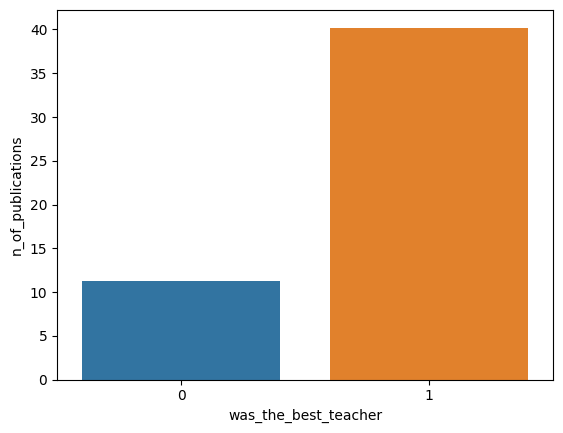

In [321]:
sns.barplot(data=df_plot_1, x="was_the_best_teacher", y="n_of_publications")

### Год старта работы в Вышке

Создадим два датасета: `best`, `not_best`.

* В датасет `best` отфильтруем тех преподавателей ОП "Политология", которые получали хотя бы раз статус лучшего преподавателя;
* В датасет `not_best` отфильтруем тех преподавателей ОП "Политология", которые ни разу не получали статус лучшего преподавателя.

In [322]:
best = df[df['was_the_best_teacher'] == 1]
not_best = df[df['was_the_best_teacher'] == 0]

Теперь посчитаем год начала работы в Вышке для каждой из группы преподавателей.

In [323]:
# для "лучших преподавателей" - сколько человек в каком году начали работать
for_plot_best = best['year_start_in_hse'].value_counts().reset_index()
for_plot_best.sort_values('year_start_in_hse', inplace=True)
for_plot_best.columns = ['year', 'count']
for_plot_best

,year,count
13,1999,1
10,2002,1
9,2003,1
11,2004,1
5,2005,2
14,2007,1
4,2008,2
2,2009,4
7,2010,2
1,2011,4


In [324]:
# для не "лучших преподавателей" - сколько человек в каком году начали работать
for_plot_not_best = not_best['year_start_in_hse'].value_counts().reset_index()
for_plot_not_best.sort_values('year_start_in_hse', inplace=True)
for_plot_not_best.columns = ['year', 'count']
for_plot_not_best

,year,count
15,1995,1
14,1998,1
16,2003,1
18,2004,1
12,2006,1
19,2008,1
6,2009,4
10,2011,2
8,2012,2
7,2013,2


Используя комбинацию `seaborn` и `matplotlib`, нарисуем два barplot'а чтобы понять, в какие годы приходило больше "лучших преподавателей", а в какие – тех преподавателей ОП "Политология", которые этот статус еще не получили.

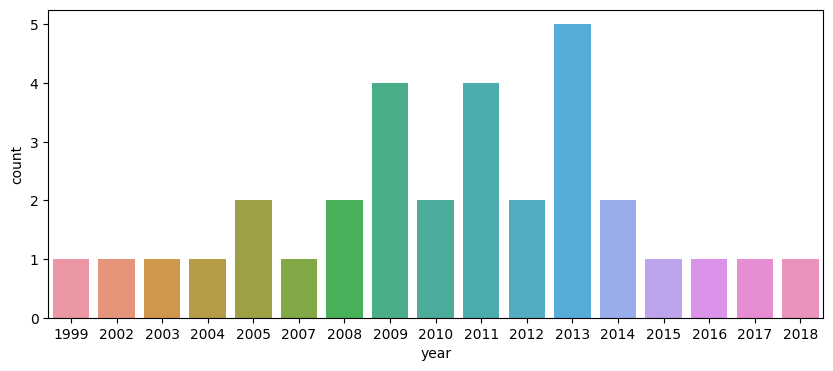

In [327]:
plt.figure(figsize=(10,4))
graph = sns.barplot(data=for_plot_best, x="year", y="count")

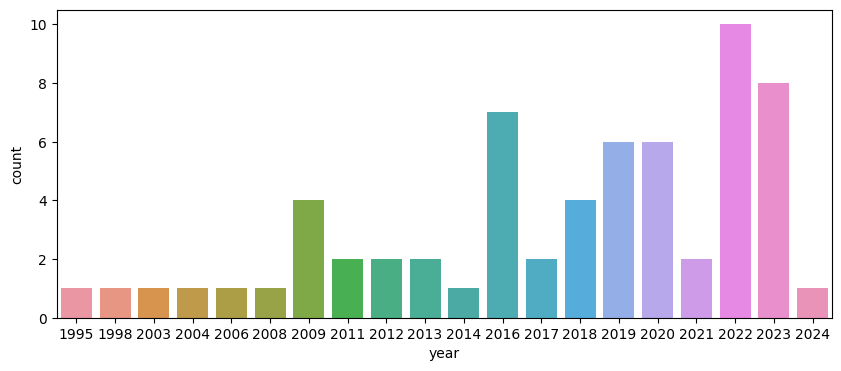

In [329]:
plt.figure(figsize=(10, 4))
graph = sns.barplot(data=for_plot_not_best, x="year", y="count")

Как мы можем понять по этому графику, то больше всего "лучших преподавателей" ОП "Политология" приходило в университет примерно в 2008-2014 годах. Пик же прихода в Вышку преподавателей без этого статуса сильно позднее – наблюдается волна в 2016-2020 годах и в 2022-2023 соответственно.

<p></p>
<center><b><font size=4>Задача №4 – Extra</font></b></center>

Если вы ушли в материале вперед, то можете поиграть с настройками этого графика. Я бы посоветовала вам:
* Добавить название графика;
* Поменять названия осей на русскоязычные.

Вы также можете строить в `matplotlib.pyplot` scatterplot'ы – или **графики рассеивания**. Они демонстрируют меру связи между двумя количественными переменными.

Что мы можем сказать по этому графику? Кажется, преподаватели, которые дольше в Вышке, имеют больше шансов написать больше публикаций.

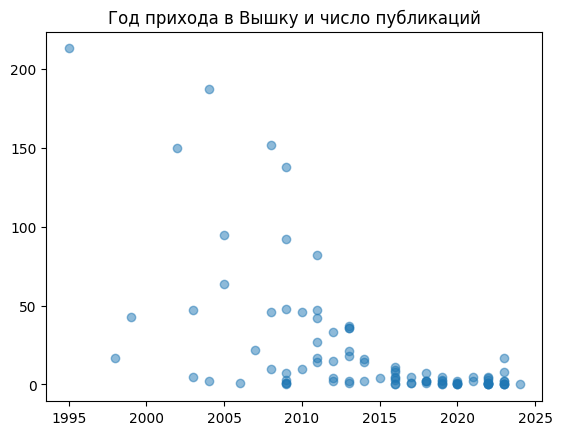

In [343]:
plt.scatter(df['year_start_in_hse'], df['n_of_publications'], alpha=0.5);
plt.title('Год прихода в Вышку и число публикаций');

А что если мы хотим сказать что-то в разрезе статуса "Лучший преподаватель"? У большинства функций для создания графиков есть параметр `hue`, куда можно передать название переменной, по которой будет происходить разделение по цвету и легенде на графике. Хотя график неидеален, но мы уже можем заметитть, что "лучшие преподаватели" находятся в Университете как минимум по 4-5 лет (самая правая точка – у 2019 года), и что у них чаще больше публикаций, нежели у преподавателей без этого статуса.

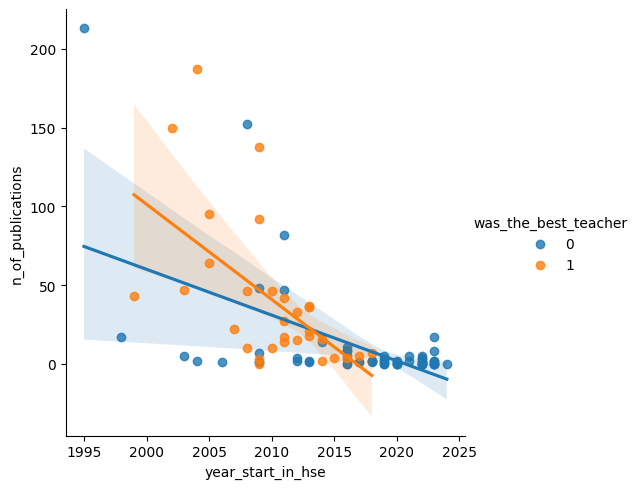

In [341]:
sns.lmplot(x='year_start_in_hse', y='n_of_publications', data=df, hue='was_the_best_teacher');

<p></p>
<center><b><font size=4>Задача №5 – Extra</font></b></center>

Если вы ушли вперед, проанализируйте – есть ли гендерные отличия в получении статуса "Лучший преподаватель" - или – есть ли отличия в получении статуса "Лучший преподаватель" для преподавателей с разным числом иностранных языков. Используйте описательные статистики, графики, при желании – статистические критерии.

<p></p>
<center><b><font size=4>Задача №6 – Extra</font></b></center>

Порефлексируйте над следующим: 
1. Как вы считаете, можно ли сказать, что наши данные полные? Почему вы можете сказать что они полные/не полные?
2. Обладают ли страницы преподавателей какой-то спецификой в отношении вопроса времени?
3. Могут ли данные, собранные нами, как-то повлиять на жизни этих лиц, если будут опубликованы публично?

<p></p>
<center><b><font size=4>P. S.</font></b></center>


Возможно, мы не успели до конца разобрать материал этого ноутбука, но это не страшно. Его главной целью было отточить ваши навыки работы с данными и сбора их в один датафрейм, а также рассказать вам о том что и как можно анализировать на ваших данных как только вы их собрали. Описательные статистики и графики, представленные выше, релевантны только для преподавателей ОП "Политология" в начале календарного 2024 года, но, надеюсь, это было вам полезно и интересно.